# Distance Analysis: tonsil-codex-stanford and esophagus-codex-stanford

> Analyze and visualize cell-to-nearest-endothelial-cell distance distributions for the `tonsil-codex-stanford` and `esophagus-codex-stanford` datasets.

In [1]:
import numpy as np
import pandas as pd
import os
import json
import requests
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
import plotly.express as px

from _cde_compute_edges_from_nodes import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# suppress warnings
import warnings
warnings.filterwarnings("ignore")   

In [2]:
basepath = "/u/yashjain/hra-cell-distance-analysis/data"
dataset_dir = "tonsil-esophagus-codex-stanford" # This variable is used only for figures.
dataset_dir_1 = "tonsil-codex-stanford" # This variable is used for data loading dataset 1.
dataset_dir_2 = "esophagus-codex-stanford" # This variable is used for data loading dataset 2.
data_filedir_1 = os.path.join("data-processed-nodes-with-harmonized-cell-types", dataset_dir_1)
output_edge_dir_1 = os.path.join("data-processed-edges", dataset_dir_1)
data_filedir_2 = os.path.join("data-processed-nodes-with-harmonized-cell-types", dataset_dir_2)
output_edge_dir_2 = os.path.join("data-processed-edges", dataset_dir_2)
figures_output_dir = "generated-figures"

In [3]:
# Function to load your data
def load_data(path, edges=False):
    if edges:
        column_names = ['cell_id', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2']
        data = pd.read_csv(path, header=None, names=column_names)
    else:
        data = pd.read_csv(path)
    return data

In [4]:
# Function to read all files ending with "-nodes.csv" in the `data_filedir` directory into a single DataFrame. 
# Another additional column `Dataset` is added to identify the dataset name which comes from the filename before the `-nodes.csv` suffix.

# Additionally, function reads all files ending with "-edges.csv" in the `output_edge_dir` directory into a single DataFrame. 
# Three additional columns are added "Dataset", "Anchor Cell Type", and "Anchor Cell Type Level" to identify the dataset name, anchor cell type, and anchor cell type level respectively which come from the filename before the `.csv` suffix.
# The three additional columns are created by splitting the filename on the `-` character, and extracting the relevant parts.
# On splitting, the first part is the dataset name, second part is the anchor cell type level, and third part is the anchor cell type, and last part is the `edges` suffix.
# When reading files, check if the file has the correct format (i.e., ends with `-edges.csv`).

# Additionally, the function merges the edges DataFrame with the nodes DataFrame to get the cell type information for the anchor cells.
# This is done by reading the corresponding nodes file from the `data_filedir` directory for each edges file, and merging it with the edges DataFrame on the `cell_id` column.
# The merged DataFrame contains the edges with additional columns for the cell type information.

# The function returns three DataFrames:
# 1. `merged_nodes`: DataFrame containing all nodes with an additional column `Dataset`.
# 2. `merged_edges`: DataFrame containing all edges with additional columns `Dataset`, `Anchor Cell Type`, and `Anchor Cell Type Level`.
# 3. `merged_nodes_for_all_edges`: DataFrame containing all edges with additional columns `Dataset`, `Anchor Cell Type`, `Anchor Cell Type Level`, and the cell type information for cells.
def read_all_edge_datasets(basepath, data_filedir, output_edge_dir):
    all_nodes_files = []
    all_edges_files = []
    all_nodes_edges_files = []
    for file in os.listdir(os.path.join(basepath, output_edge_dir)):
        if file.endswith("-edges.csv"):
            file_path = os.path.join(basepath, output_edge_dir, file)
            dataset_name, anchor_cell_type_level, anchor_cell_type = file.replace("-edges.csv", "").split('-')
            edges_df = load_data(file_path, edges=False)
            edges_df['Dataset'] = dataset_name
            edges_df['Anchor Cell Type'] = anchor_cell_type
            edges_df['Anchor Cell Type Level'] = anchor_cell_type_level
            edges_df.rename(columns={"distance": "Distance"}, inplace=True) # Rename column "distance" to "Distance".
            all_edges_files.append(edges_df)

            # Read the corresponding nodes file from data_filedir to get the cell type information
            nodes_file_path = os.path.join(basepath, data_filedir, f"{dataset_name}-nodes.csv")
            nodes_df = load_data(nodes_file_path)
            nodes_df['Dataset'] = dataset_name
            all_nodes_files.append(nodes_df)

            # Add a new 'cell_id' column to nodes_df
            nodes_df['cell_id'] = range(len(nodes_df))
            # Set 'cell_id' column as index for nodes_df
            nodes_df.set_index('cell_id', inplace=True)
            # Merge edges_df with nodes_df to get the cell type information for the anchor cells
            edges_nodes_df = pd.merge(edges_df, nodes_df[['Level Three Cell Type', 'Level Two Cell Type', 'Level One Cell Type']], how='left', left_on='cell_id', right_index=True)
            all_nodes_edges_files.append(edges_nodes_df)

    
    merged_edges = pd.concat(all_edges_files, ignore_index=True)
    merged_nodes = pd.concat(all_nodes_files, ignore_index=True)
    merged_nodes_for_all_edges = pd.concat(all_nodes_edges_files, ignore_index=True) 

    return merged_nodes, merged_edges, merged_nodes_for_all_edges

In [5]:
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")

## Get initial statistics and identify endothelial cell categories for dataset.

In [6]:
# Read all datasets from Dataset 1
df_all_nodes_1, df_all_edges_1, df_all_edges_with_cell_types_1 = read_all_edge_datasets(basepath, data_filedir_1, output_edge_dir_1)

# Create a column 'Tissue Type' in all three DataFrames with the value dataset_dir_1
df_all_nodes_1['Tissue Type'] = dataset_dir_1
df_all_edges_1['Tissue Type'] = dataset_dir_1
df_all_edges_with_cell_types_1['Tissue Type'] = dataset_dir_1

# Read all datasets from Dataset 2
df_all_nodes_2, df_all_edges_2, df_all_edges_with_cell_types_2 = read_all_edge_datasets(basepath, data_filedir_2, output_edge_dir_2)

# Create a column 'Tissue Type' in all three DataFrames with the value dataset_dir_2
df_all_nodes_2['Tissue Type'] = dataset_dir_2
df_all_edges_2['Tissue Type'] = dataset_dir_2
df_all_edges_with_cell_types_2['Tissue Type'] = dataset_dir_2

# Merge the two datasets
df_all_nodes = pd.concat([df_all_nodes_1, df_all_nodes_2], ignore_index=True)
df_all_edges = pd.concat([df_all_edges_1, df_all_edges_2], ignore_index=True)
df_all_edges_with_cell_types = pd.concat([df_all_edges_with_cell_types_1, df_all_edges_with_cell_types_2], ignore_index=True)

In [7]:
df_all_nodes.head(5)

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset,Tissue Type
0,148.538,1325.532,Innate,lymphoid cell:innate,innate lymphoid cell,CL:0001065,skos:exactMatch,lymphoid cell,lymphocyte,CL:0000542,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,tonsil,tonsil-codex-stanford
1,2061.813,928.551,Innate,lymphoid cell:innate,innate lymphoid cell,CL:0001065,skos:exactMatch,lymphoid cell,lymphocyte,CL:0000542,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,tonsil,tonsil-codex-stanford
2,944.762,1806.961,PDPN,stromal cell:podoplanin+,stromal cell:podoplanin-positive,CL:0000499,skos:narrowMatch,stromal cell,stromal cell,CL:0000499,skos:exactMatch,mesenchymal cell,mesenchymal cell,CL:0008019,skos:exactMatch,tonsil,tonsil-codex-stanford
3,3367.741,300.092,Endothelial,endothelial cell,endothelial cell,CL:0000115,skos:exactMatch,endothelial cell,endothelial cell,CL:0000115,skos:exactMatch,endothelial cell,endothelial cell,CL:0000115,skos:exactMatch,tonsil,tonsil-codex-stanford
4,1806.961,710.645,Innate,lymphoid cell:innate,innate lymphoid cell,CL:0001065,skos:exactMatch,lymphoid cell,lymphocyte,CL:0000542,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,tonsil,tonsil-codex-stanford


In [8]:
# Print the total number of unique cell types per dataset. Compute separately for each cell type column (Level One Cell Type, Level Two Cell Type, Level Three Cell Type, Original Cell Type).
print("Total number of unique cell types per cell type annnotation level:")
unique_cell_types = {
    'Original Cell Type': df_all_nodes['Original Cell Type'].nunique(),
    'Level Three Cell Type': df_all_nodes['Level Three Cell Type'].nunique(),
    'Level Two Cell Type': df_all_nodes['Level Two Cell Type'].nunique(),
    'Level One Cell Type': df_all_nodes['Level One Cell Type'].nunique()
}
for cell_type, count in unique_cell_types.items():
    print(f"{cell_type}: {count}")

Total number of unique cell types per cell type annnotation level:
Original Cell Type: 13
Level Three Cell Type: 13
Level Two Cell Type: 11
Level One Cell Type: 5


In [9]:
# Save the unique cell types containing "endothelial" in name per cell type column (Level One Cell Type, Level Two Cell Type, Level Three Cell Type, Original Cell Type) to a dictionary where the key is the level and the value is a list of unique cell types.
endothelial_cell_types = {
    'Original Cell Type': df_all_nodes[df_all_nodes['Original Cell Type'].str.contains("endothelial", case=False, na=False)]['Original Cell Type'].unique().tolist(),
    'Level Three Cell Type': df_all_nodes[df_all_nodes['Level Three Cell Type'].str.contains("endothelial", case=False, na=False)]['Level Three Cell Type'].unique().tolist(),
    'Level Two Cell Type': df_all_nodes[df_all_nodes['Level Two Cell Type'].str.contains("endothelial", case=False, na=False)]['Level Two Cell Type'].unique().tolist(),
    'Level One Cell Type': df_all_nodes[df_all_nodes['Level One Cell Type'].str.contains("endothelial", case=False, na=False)]['Level One Cell Type'].unique().tolist()
}

print("\nEndothelial cell types per cell type annotation level:")
for level, cell_types in endothelial_cell_types.items():
    print(f"\n{level}:")
    for cell in cell_types:
        print(f"  - {cell}")


Endothelial cell types per cell type annotation level:

Original Cell Type:
  - Endothelial

Level Three Cell Type:
  - endothelial cell

Level Two Cell Type:
  - endothelial cell

Level One Cell Type:
  - endothelial cell


In [10]:
type_field_list = ["Level Three Cell Type", "Level Two Cell Type", "Level One Cell Type"] # Skipping Original Cell Type as it is not a hierarchical level.

# Define the anchor cell type (type of endothelial cell) for each level in type_field_list based on available categories in the previous cell. The distance analysis at all three levels will be limited to the specified anchor cell type.
anchor_cell_type_dict = {
    'Level Three Cell Type': 'endothelial cell',
    'Level Two Cell Type': 'endothelial cell',
    'Level One Cell Type': 'endothelial cell'
}

## Process datasets to add region information to Nodes files.

In [11]:
# Create a dictionary to map skin regions to correct condition.
region_map = {dataset_dir_1:'tonsil-codex-stanford',
 dataset_dir_2:'esophagus-codex-stanford', 
}

# Define the standard region sequence for plots
regions = ['tonsil-codex-stanford', 'esophagus-codex-stanford']

In [12]:
df_all_nodes.head()

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset,Tissue Type
0,148.538,1325.532,Innate,lymphoid cell:innate,innate lymphoid cell,CL:0001065,skos:exactMatch,lymphoid cell,lymphocyte,CL:0000542,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,tonsil,tonsil-codex-stanford
1,2061.813,928.551,Innate,lymphoid cell:innate,innate lymphoid cell,CL:0001065,skos:exactMatch,lymphoid cell,lymphocyte,CL:0000542,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,tonsil,tonsil-codex-stanford
2,944.762,1806.961,PDPN,stromal cell:podoplanin+,stromal cell:podoplanin-positive,CL:0000499,skos:narrowMatch,stromal cell,stromal cell,CL:0000499,skos:exactMatch,mesenchymal cell,mesenchymal cell,CL:0008019,skos:exactMatch,tonsil,tonsil-codex-stanford
3,3367.741,300.092,Endothelial,endothelial cell,endothelial cell,CL:0000115,skos:exactMatch,endothelial cell,endothelial cell,CL:0000115,skos:exactMatch,endothelial cell,endothelial cell,CL:0000115,skos:exactMatch,tonsil,tonsil-codex-stanford
4,1806.961,710.645,Innate,lymphoid cell:innate,innate lymphoid cell,CL:0001065,skos:exactMatch,lymphoid cell,lymphocyte,CL:0000542,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,tonsil,tonsil-codex-stanford


In [13]:
# Iterate through the df_all_data dataframe to create new column "Unique Region" based on the "Tissue Type" column.
# The "Unique Region" column is created by mapping the region names based on the full dataset name.
df_all_nodes['Unique Region'] = df_all_nodes['Tissue Type'].map(region_map)

# Check if the new columns are created correctly.
df_all_nodes[['Tissue Type', 'Unique Region']].head(5)

,Tissue Type,Unique Region
0,tonsil-codex-stanford,tonsil-codex-stanford
1,tonsil-codex-stanford,tonsil-codex-stanford
2,tonsil-codex-stanford,tonsil-codex-stanford
3,tonsil-codex-stanford,tonsil-codex-stanford
4,tonsil-codex-stanford,tonsil-codex-stanford


In [14]:
# Print all unique regions in the data.
print("\nUnique Regions in the data:")
print(df_all_nodes['Unique Region'].unique())

# Print the total number of unique regions.
print(f"Total number of unique regions: {df_all_nodes['Unique Region'].nunique()}")

# Print number of unique datasets per unique region.
print("\nNumber of unique datasets per unique region:")
for region in df_all_nodes['Unique Region'].unique():
    num_datasets = df_all_nodes[df_all_nodes['Unique Region'] == region]['Dataset'].nunique()
    print(f"{region}: {num_datasets}")



Unique Regions in the data:


['tonsil-codex-stanford' 'esophagus-codex-stanford']
Total number of unique regions: 2

Number of unique datasets per unique region:
tonsil-codex-stanford: 1
esophagus-codex-stanford: 1


## Process datasets to add region information to Edges files.

In [15]:
df_all_edges.head(5)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level,Tissue Type
0,0,148.538,1325.532,0,96.889,1333.449,0,52.252254,tonsil,endothelial cell,Level Three Cell Type,tonsil-codex-stanford
1,190,183.599,1254.656,0,96.889,1333.449,0,117.162114,tonsil,endothelial cell,Level Three Cell Type,tonsil-codex-stanford
2,242,180.583,1235.052,0,109.330,1150.227,0,110.780281,tonsil,endothelial cell,Level Three Cell Type,tonsil-codex-stanford
3,609,163.618,1238.445,0,109.330,1150.227,0,103.583794,tonsil,endothelial cell,Level Three Cell Type,tonsil-codex-stanford
4,836,88.595,1252.394,0,56.550,1316.484,0,71.654798,tonsil,endothelial cell,Level Three Cell Type,tonsil-codex-stanford


In [16]:
# Process the edge data to create new columns "Unique Region" based on the "Tissue Type" column, similar to how it was done for the node data.
df_all_edges['Unique Region'] = df_all_edges['Tissue Type'].map(region_map)

# Check if the new columns are created correctly.
df_all_edges[['Tissue Type', 'Unique Region']].head(5)

,Tissue Type,Unique Region
0,tonsil-codex-stanford,tonsil-codex-stanford
1,tonsil-codex-stanford,tonsil-codex-stanford
2,tonsil-codex-stanford,tonsil-codex-stanford
3,tonsil-codex-stanford,tonsil-codex-stanford
4,tonsil-codex-stanford,tonsil-codex-stanford


In [17]:
# Print all unique regions in the data.
print("\nUnique Regions in the data:")
print(df_all_edges['Unique Region'].unique())

# Print the total number of unique regions.
print(f"Total number of unique regions: {df_all_edges['Unique Region'].nunique()}")

# Print number of unique datasets per unique region.
print("\nNumber of unique datasets per unique region:")
for region in df_all_edges['Unique Region'].unique():
    num_datasets = df_all_edges[df_all_edges['Unique Region'] == region]['Dataset'].nunique()
    print(f"{region}: {num_datasets}")



Unique Regions in the data:
['tonsil-codex-stanford' 'esophagus-codex-stanford']
Total number of unique regions: 2

Number of unique datasets per unique region:
tonsil-codex-stanford: 1
esophagus-codex-stanford: 1


In [18]:
df_all_edges_with_cell_types['Unique Region'] = df_all_edges_with_cell_types['Tissue Type'].map(region_map)

# Check if the new columns are created correctly.
df_all_edges_with_cell_types[['Tissue Type', 'Unique Region']].head(5)

,Tissue Type,Unique Region
0,tonsil-codex-stanford,tonsil-codex-stanford
1,tonsil-codex-stanford,tonsil-codex-stanford
2,tonsil-codex-stanford,tonsil-codex-stanford
3,tonsil-codex-stanford,tonsil-codex-stanford
4,tonsil-codex-stanford,tonsil-codex-stanford


In [19]:
df_all_nodes.head(1)

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset,Tissue Type,Unique Region
0,148.538,1325.532,Innate,lymphoid cell:innate,innate lymphoid cell,CL:0001065,skos:exactMatch,lymphoid cell,lymphocyte,CL:0000542,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,tonsil,tonsil-codex-stanford,tonsil-codex-stanford


In [20]:
df_all_edges.head(1)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level,Tissue Type,Unique Region
0,0,148.538,1325.532,0,96.889,1333.449,0,52.252254,tonsil,endothelial cell,Level Three Cell Type,tonsil-codex-stanford,tonsil-codex-stanford


In [21]:
df_all_edges_with_cell_types.head(1)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level,Level Three Cell Type,Level Two Cell Type,Level One Cell Type,Tissue Type,Unique Region
0,0,148.538,1325.532,0,96.889,1333.449,0,52.252254,tonsil,endothelial cell,Level Three Cell Type,lymphoid cell:innate,lymphoid cell,immune cell,tonsil-codex-stanford,tonsil-codex-stanford


## Node Analysis

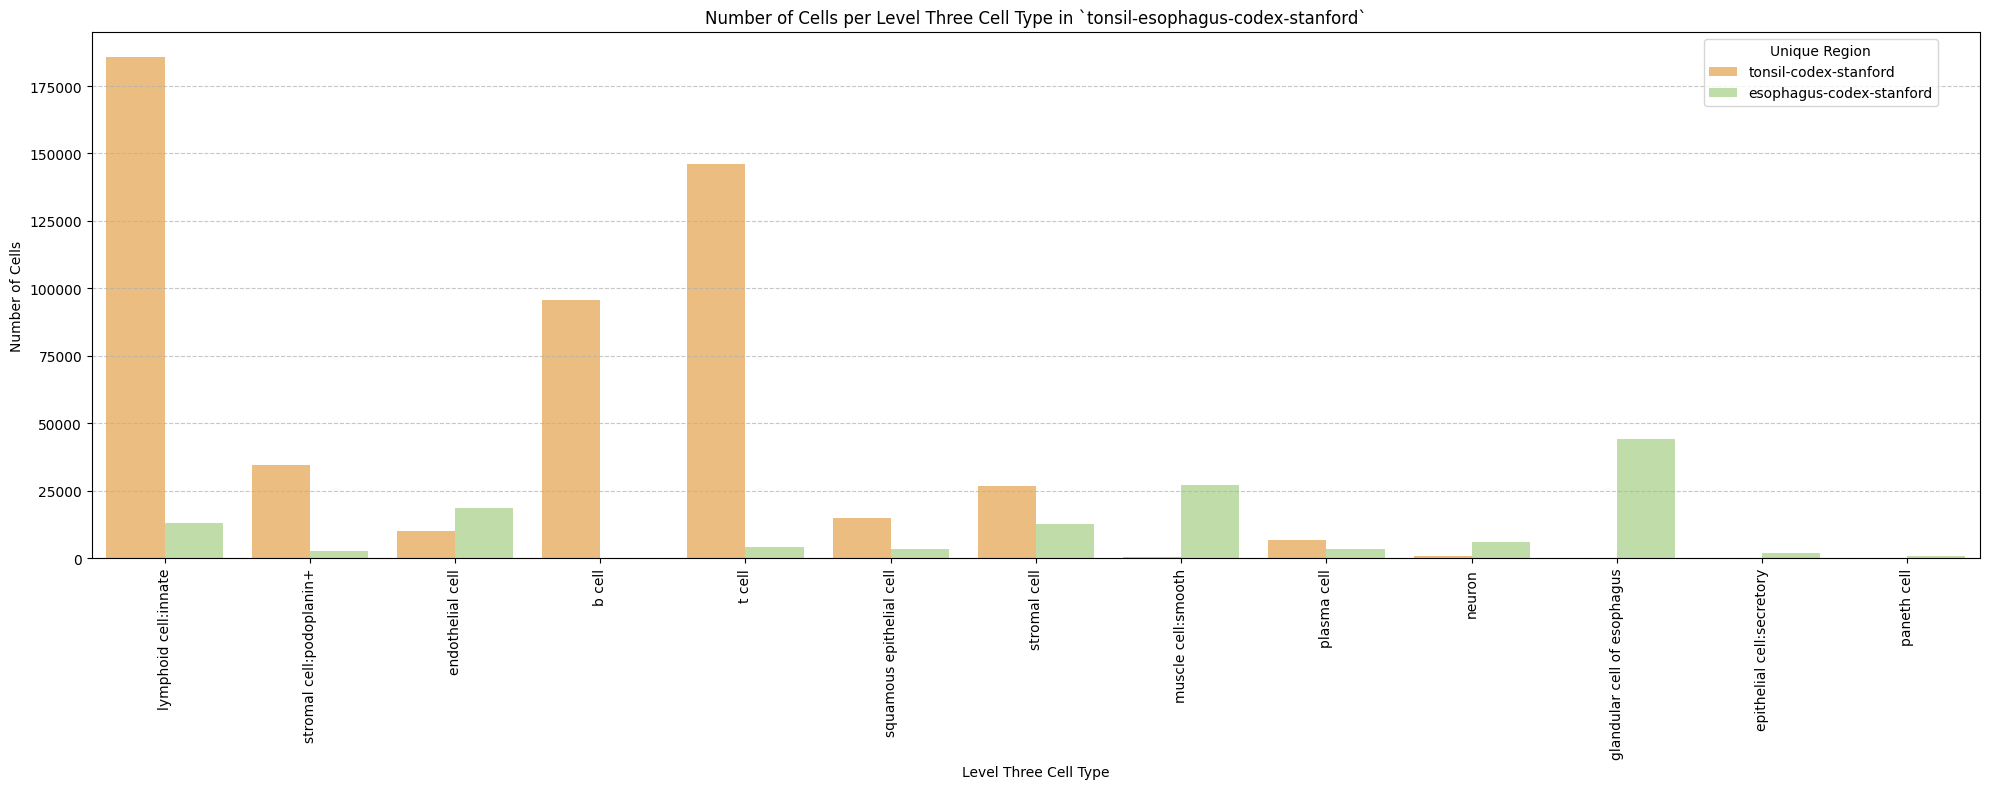

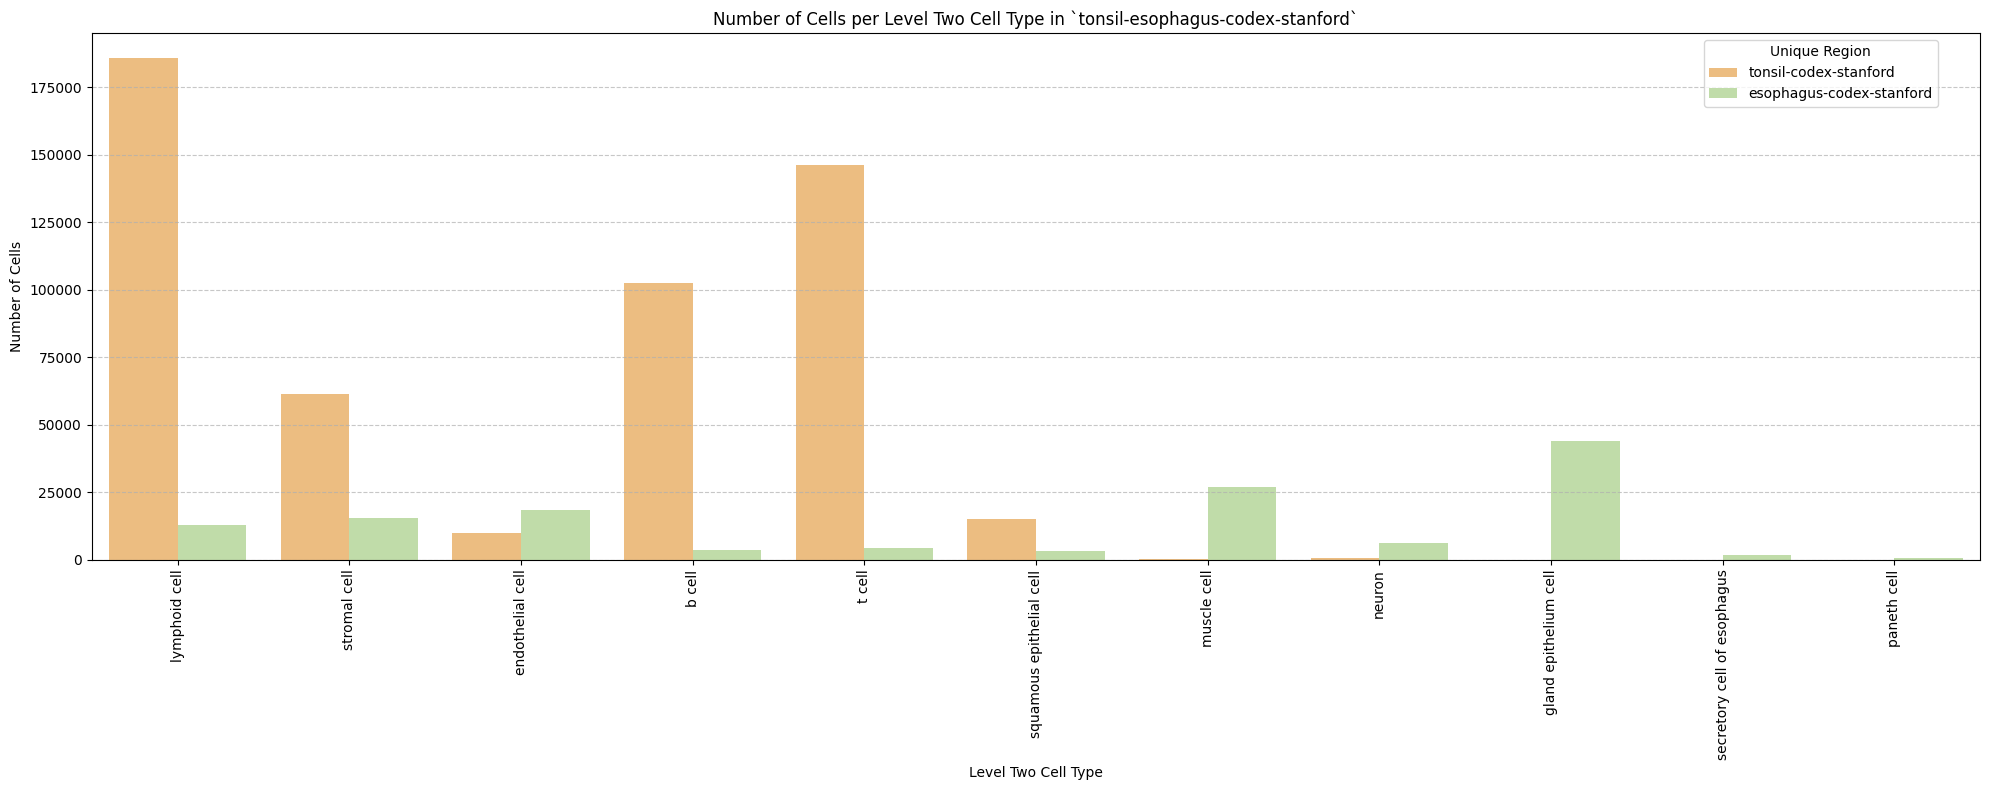

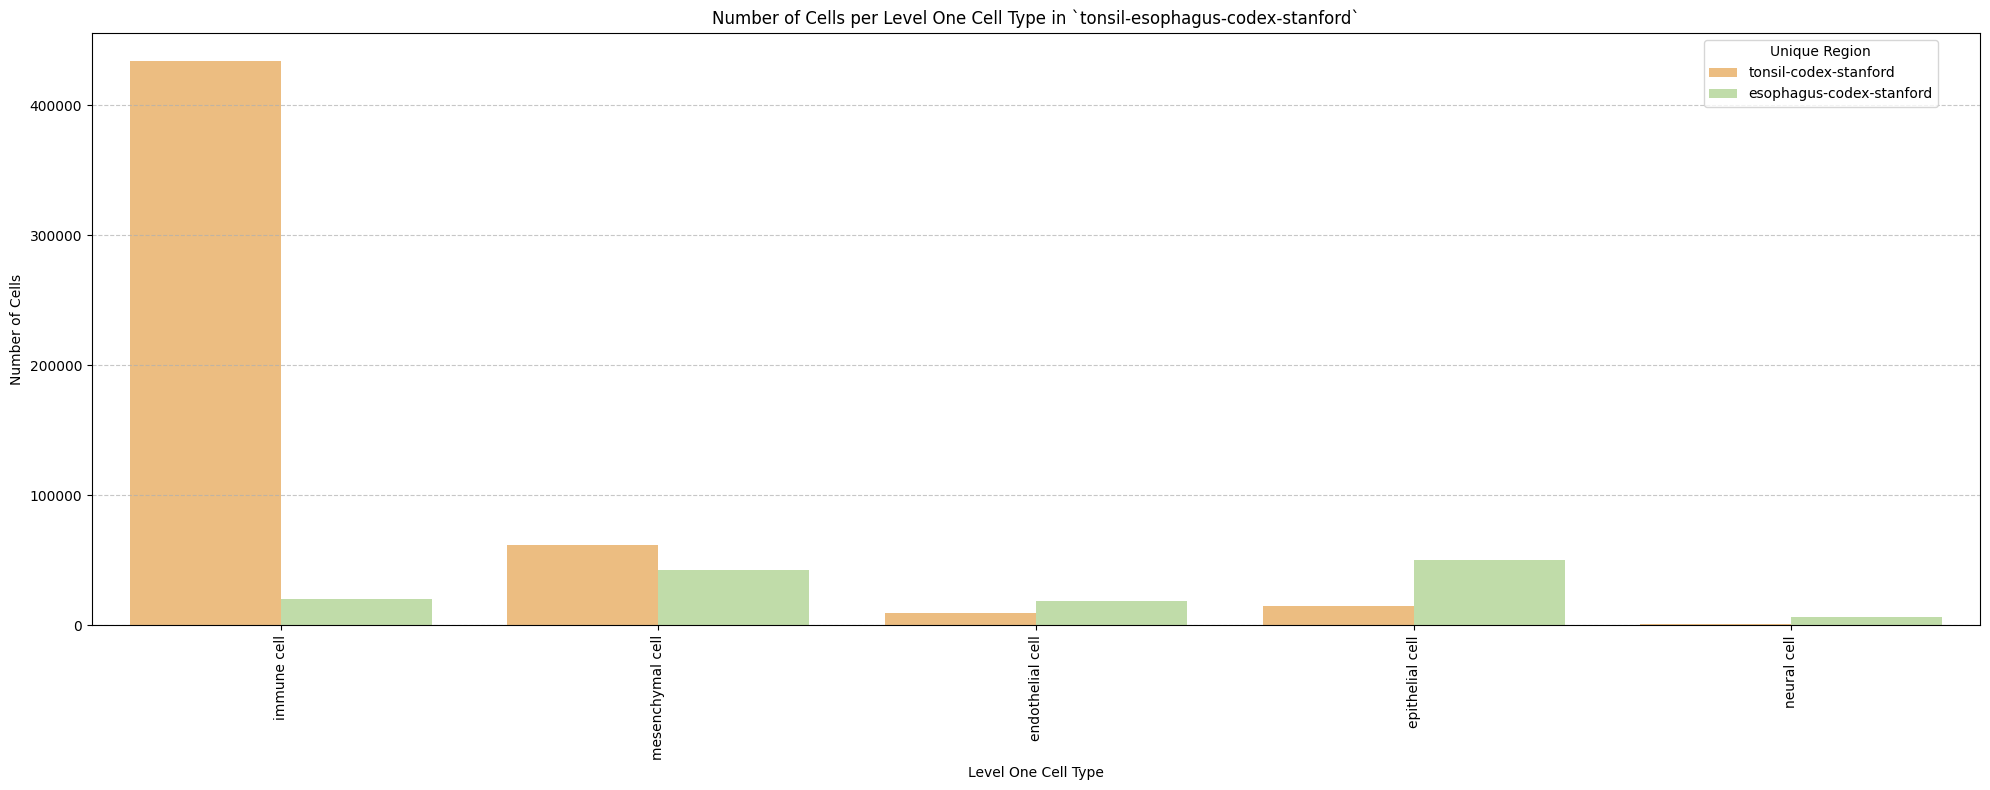

In [22]:
# Plot number of cells per cell type in the same plot. Color by cell type and unique region. Output figure saved in existing `figures_output_dir`.
def plot_cells_per_celltype(df, type_field, output_dir):
    plt.figure(figsize=(20, 8))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    sns.countplot(data=df, x=type_field, palette='Spectral', hue='Unique Region')
    plt.title(f'Number of Cells per {type_field} in `{dataset_dir}`')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{type_field}.png'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{type_field}.svg'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.legend(title='Unique Region', bbox_to_anchor=(0.85, 1), loc='upper left')
    plt.xlabel(type_field)

    # For numbers on y-axis, do not use scientific notation.
    plt.ticklabel_format(style='plain', axis='y')
    # Set y-axis label
    plt.ylabel('Number of Cells')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    # Show the plot
    plt.show()
    plt.close()
for type_field in type_field_list:
    plot_cells_per_celltype(df_all_nodes, type_field, os.path.join(basepath, figures_output_dir))

## Distance Analysis

In [23]:
# Get mean, median, minimum, maximum distance per unique region per anchor cell type.
df_distance_stats = df_all_edges_with_cell_types.groupby(['Unique Region', 'Anchor Cell Type', 'Anchor Cell Type Level']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
# Print the first few rows of the distance statistics DataFrame.
df_distance_stats

,Unique Region,Anchor Cell Type,Anchor Cell Type Level,mean_distance,median_distance,min_distance,max_distance
0,esophagus-codex-stanford,endothelial cell,Level One Cell Type,26.201365,21.751953,2.384357,193.046457
1,esophagus-codex-stanford,endothelial cell,Level Three Cell Type,26.201365,21.751953,2.384357,193.046457
2,esophagus-codex-stanford,endothelial cell,Level Two Cell Type,26.201365,21.751953,2.384357,193.046457
3,tonsil-codex-stanford,endothelial cell,Level One Cell Type,56.899226,45.210144,2.639000,199.993437
4,tonsil-codex-stanford,endothelial cell,Level Three Cell Type,56.899226,45.210144,2.639000,199.993437
5,tonsil-codex-stanford,endothelial cell,Level Two Cell Type,56.899226,45.210144,2.639000,199.993437


### Level One Cell Type Analysis

In [24]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level One Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level One Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,epithelial cell,esophagus-codex-stanford,25.325414,21.492307,2.528993,193.046457
1,epithelial cell,tonsil-codex-stanford,65.469626,55.553479,4.060414,199.673736
2,immune cell,esophagus-codex-stanford,21.482974,15.712354,2.639000,143.075846
3,immune cell,tonsil-codex-stanford,56.521626,44.457236,2.639000,199.993437
4,mesenchymal cell,esophagus-codex-stanford,29.463088,25.393686,2.384357,142.577791
5,mesenchymal cell,tonsil-codex-stanford,57.159447,47.676714,3.108822,199.931243
6,neural cell,esophagus-codex-stanford,26.639884,22.024674,3.788803,107.653801
7,neural cell,tonsil-codex-stanford,66.127466,57.077850,6.409000,194.409948


In [25]:
# Get top five and bottom five cell types with respect to mean distance in each unique region separately.
def get_top_bottom_cell_types_by_mean(df, cell_type_level, unique_region, top_n=5):
    # Filter the DataFrame for the specified unique region and cell type level
    df_filtered = df[df['Unique Region'] == unique_region]

    # Group by the specified cell type level and calculate mean distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(mean_distance=('Distance', 'mean')).reset_index()
    
    # Sort by mean distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='mean_distance', ascending=False)
    
    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types

# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in tonsil-codex-stanford:
  Level One Cell Type  mean_distance
3         neural cell      66.127466
0     epithelial cell      65.469626
2    mesenchymal cell      57.159447
1         immune cell      56.521626

Bottom 5 cell types in tonsil-codex-stanford:
  Level One Cell Type  mean_distance
3         neural cell      66.127466
0     epithelial cell      65.469626
2    mesenchymal cell      57.159447
1         immune cell      56.521626

Top 5 cell types in esophagus-codex-stanford:
  Level One Cell Type  mean_distance
2    mesenchymal cell      29.463088
3         neural cell      26.639884
0     epithelial cell      25.325414
1         immune cell      21.482974

Bottom 5 cell types in esophagus-codex-stanford:
  Level One Cell Type  mean_distance
2    mesenchymal cell      29.463088
3         neural cell      26.639884
0     epithelial cell      25.325414
1         immune cell      21.482974


In [26]:
# Get top five and bottom five cell types with respect to median distance in each unique region separately.
def get_top_bottom_cell_types_by_median(df, cell_type_level, unique_region, top_n=5):
    # Filter the DataFrame for the specified unique region and cell type level
    df_filtered = df[df['Unique Region'] == unique_region]

    # Group by the specified cell type level and calculate median distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(median_distance=('Distance', 'median')).reset_index()

    # Sort by median distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='median_distance', ascending=False)

    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types

# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in tonsil-codex-stanford:
  Level One Cell Type  median_distance
3         neural cell        57.077850
0     epithelial cell        55.553479
2    mesenchymal cell        47.676714
1         immune cell        44.457236

Bottom 5 cell types in tonsil-codex-stanford:
  Level One Cell Type  median_distance
3         neural cell        57.077850
0     epithelial cell        55.553479
2    mesenchymal cell        47.676714
1         immune cell        44.457236

Top 5 cell types in esophagus-codex-stanford:
  Level One Cell Type  median_distance
2    mesenchymal cell        25.393686
3         neural cell        22.024674
0     epithelial cell        21.492307
1         immune cell        15.712354

Bottom 5 cell types in esophagus-codex-stanford:
  Level One Cell Type  median_distance
2    mesenchymal cell        25.393686
3         neural cell        22.024674
0     epithelial cell        21.492307
1         immune cell        15.712354


In [27]:
# Calculate regional variability
def calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level):
    """    Calculate regional variability for distances in the given DataFrame.
    """
    regional_variability = df_all_edges_with_cell_type_level.groupby('Unique Region')['Distance'].agg([
        ('mean', 'mean'),
        ('std', 'std')
    ]).round(2)

    # Add CV as percentage
    regional_variability['CV (%)'] = (regional_variability['std'] / regional_variability['mean'] * 100).round(1)

    print("\nRegional Variability Analysis:")
    print("Mean: Average distance in each region")
    print("Std: Standard deviation of distances")
    print("CV: Coefficient of Variation (std/mean * 100%)")
    print(regional_variability)

    # Calculate variability for each cell type
    cell_type_variability = df_all_edges_with_cell_type_level.groupby(cell_type_level)['Distance'].agg([
        ('mean', 'mean'),
        ('std', 'std')
    ]).round(2)

    # Add CV as percentage
    cell_type_variability['CV (%)'] = (cell_type_variability['std'] / cell_type_variability['mean'] * 100).round(1)

    print("\nCell Type Variability Analysis (sorted by CV):")
    print(cell_type_variability.sort_values('CV (%)', ascending=False))

calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                          mean    std  CV (%)
Unique Region                                
esophagus-codex-stanford  26.2  17.46    66.6
tonsil-codex-stanford     56.9  42.08    74.0

Cell Type Variability Analysis (sorted by CV):
                      mean    std  CV (%)
Level One Cell Type                      
epithelial cell      34.36  29.16    84.9
neural cell          31.35  24.62    78.5
mesenchymal cell     45.67  35.37    77.4
immune cell          54.77  42.25    77.1


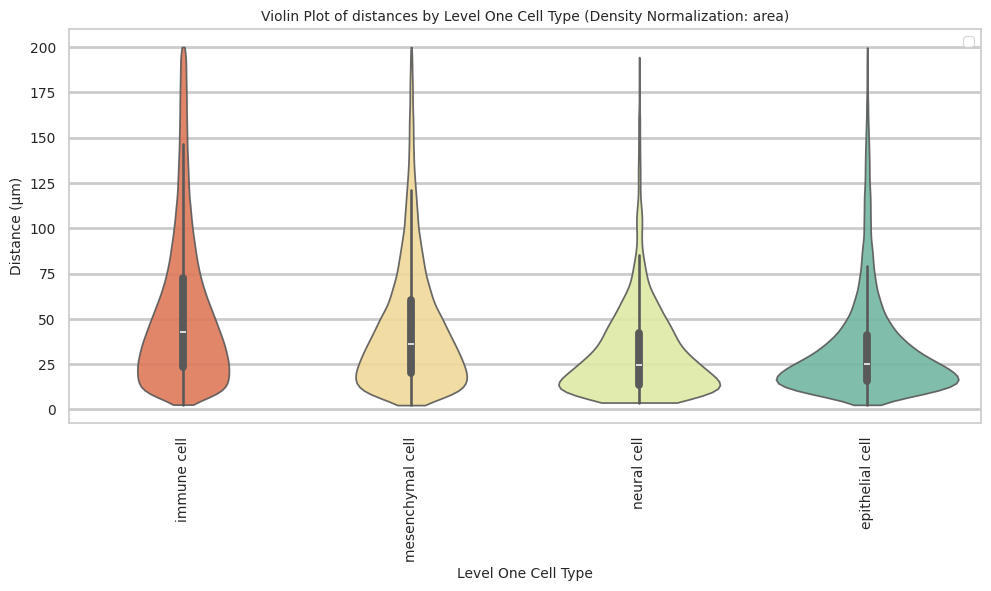

In [28]:
    # Generate Violin Plot
def plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, output_dir, density_norm='area'):
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={"grid.linewidth": 2})
    plt.figure(figsize=(10, 6))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path

    sns.violinplot(data=df_all_edges_with_cell_type_level, x=cell_type_level, y="Distance", density_norm=density_norm, common_norm=True, cut=0, inner="box", split=False, palette='Spectral', alpha=.9)

    sns.set_theme(style="whitegrid")
    sns.set_context("paper")


    font_size = 10
    plt.legend(fontsize=font_size)

    plt.title(f'Violin Plot of distances by {cell_type_level} (Density Normalization: {density_norm})', fontsize=font_size)

    plt.xlabel(f'{cell_type_level}', fontsize=font_size)
    plt.ylabel('Distance (\u03bcm)', fontsize=font_size)

    # Increase font size for all text in the figure
    plt.xticks(fontsize=font_size)
    plt.xticks(rotation=90)
    plt.yticks(fontsize=font_size)

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_cells_per_celltype_{cell_type_level}.png'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_cells_per_celltype_{cell_type_level}.svg'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.show()

plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

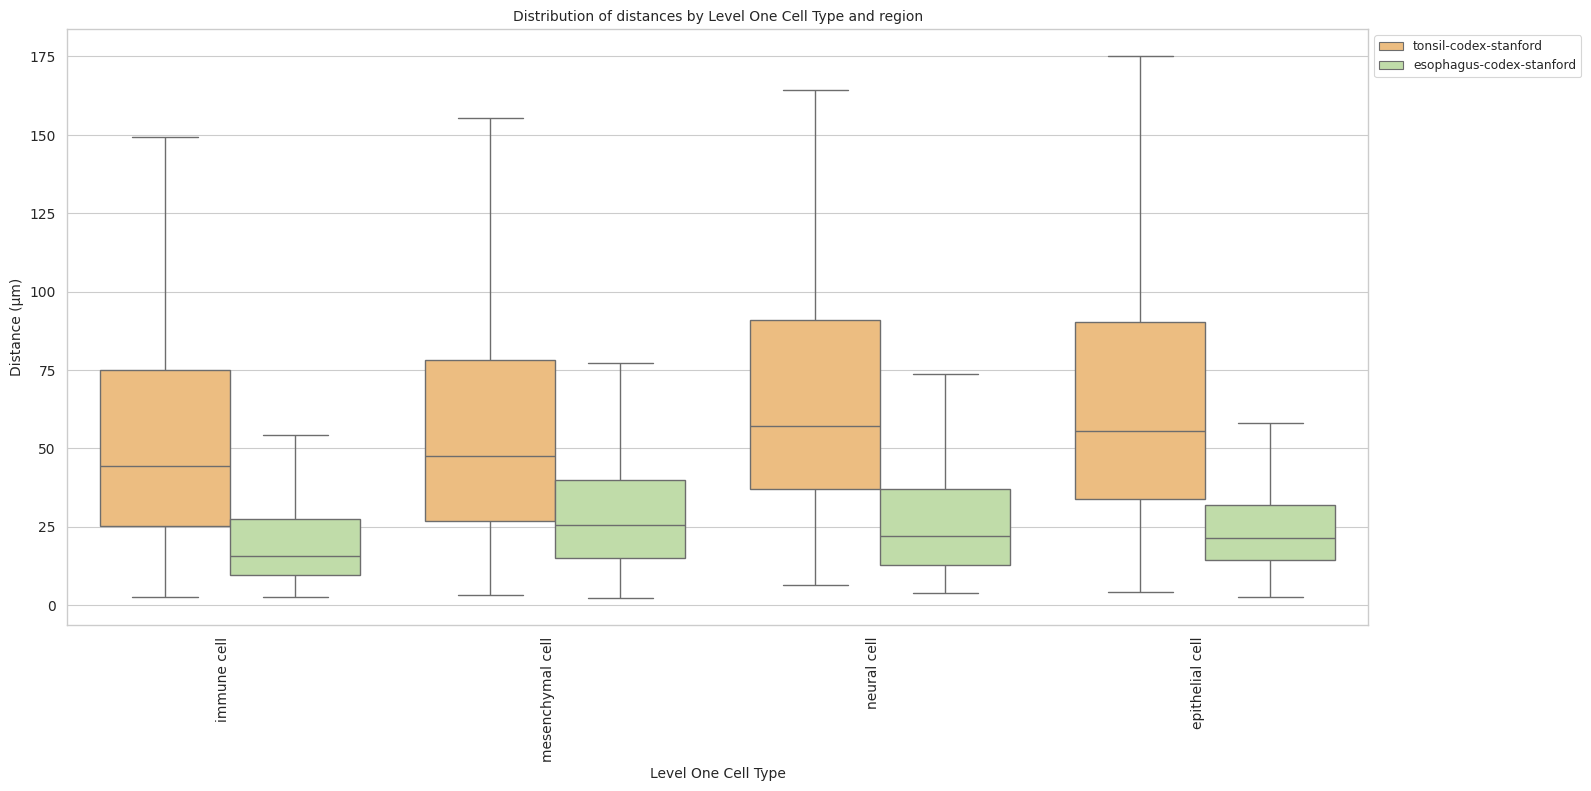

In [29]:
# Boxplots of distribution of distances by cell type and region.
def plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, output_dir):
    plt.figure(figsize=(16, 8))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    # Create categorical type with only the regions that exist in the data
    available_regions = [r for r in regions if r in df_all_edges_with_cell_type_level['Unique Region'].unique()]
    df_all_edges_with_cell_type_level['Unique Region'] = pd.Categorical(
        df_all_edges_with_cell_type_level['Unique Region'],
        categories=available_regions,
        ordered=True
    )

    # Make box plot.
    sns.boxplot(data=df_all_edges_with_cell_type_level, x=cell_type_level, y='Distance', hue='Unique Region', showfliers=False, palette='Spectral') # viridis or Spectral palette for better color distinction
    font_size = 10
    plt.xticks(rotation=90, ha='right', fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.title(f'Distribution of distances by {cell_type_level} and region', fontsize=font_size)
    plt.xlabel(f'{cell_type_level}', fontsize=font_size)
    plt.ylabel('Distance (\u03bcm)', fontsize=font_size)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_boxplots_by_region_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_boxplots_by_region_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.show()

plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

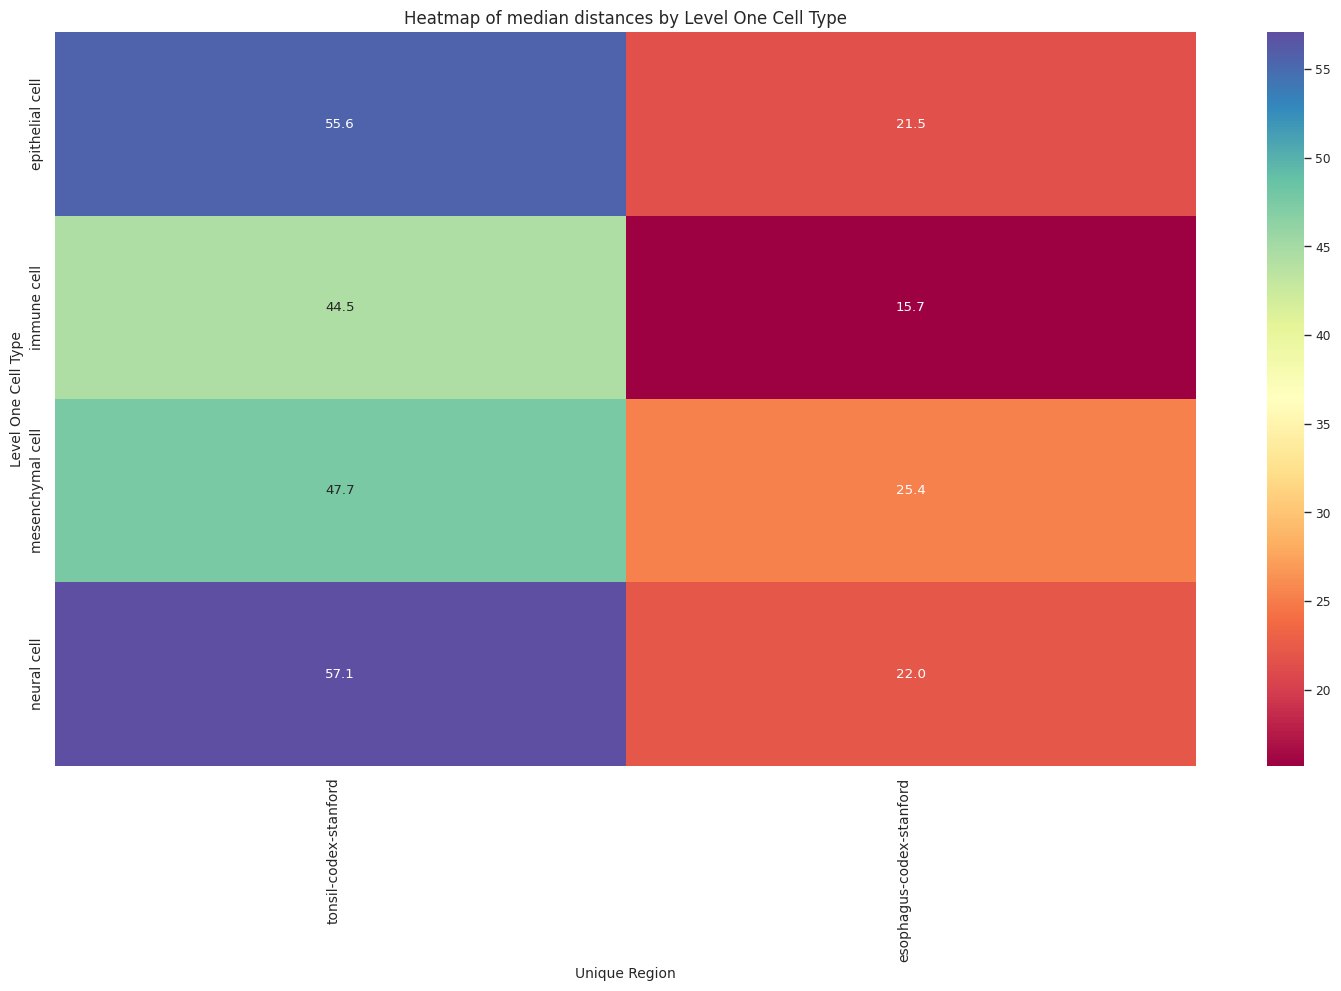

In [30]:
# Boxplots of distribution of distances by cell type and region.
def plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, output_dir):
    pivot_data = df_all_edges_with_cell_type_level.pivot_table(
    values='Distance',
    index=cell_type_level,
    columns='Unique Region',
    aggfunc='median'
    )

    plt.figure(figsize=(15, 10))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='Spectral')
    plt.title(f'Heatmap of median distances by {cell_type_level}', fontsize=12)

    font_size = 10
    plt.xticks(rotation=90, ha='right', fontsize=font_size)
    plt.yticks(fontsize=font_size)

    plt.xlabel('Unique Region', fontsize=font_size)
    plt.ylabel(f'{cell_type_level}', fontsize=font_size)
    
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_heatmap_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_heatmap_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.show()

plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

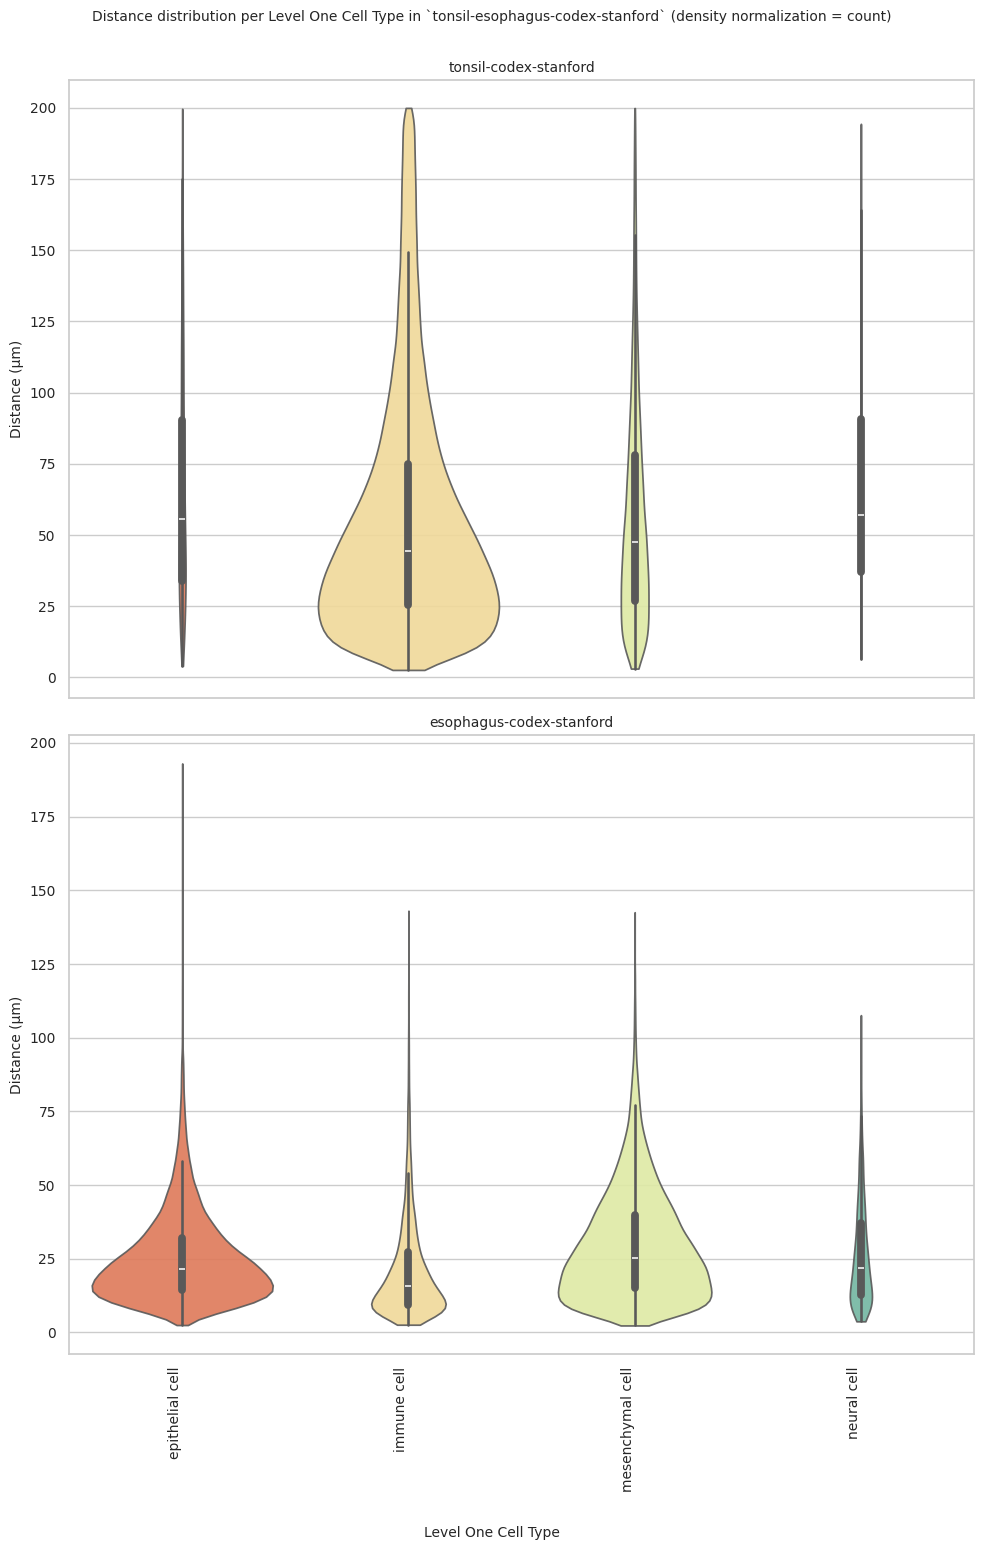

In [31]:
# Generate Violin Plot per unique region in both small intestine and large intestine. Create for all 8 regions as 8 subplots.
def plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, output_dir, density_norm="area"):
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={"grid.linewidth": 1})
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    font_size = 10
    fig, axs = plt.subplots(2, 1, figsize=(10, 15)) # Adjusted figsize for horizontal layout
    fig.suptitle(f'Distance distribution per {cell_type_level} in `{dataset_dir}` (density normalization = {density_norm})', fontsize=font_size, y=1)

    # Keep the sequence of Cell Types consistent across plots.
    cell_types = sorted(df_all_edges_with_cell_type_level[cell_type_level].unique())

    # Create a color palette based on the number of unique classes
    color_palette = sns.color_palette("Spectral", n_colors=len(cell_types))

    # Create a dictionary mapping class to color
    class_color_dict = dict(zip(cell_types, color_palette))

    for i, region in enumerate(regions):
        data_reg = df_all_edges_with_cell_type_level[df_all_edges_with_cell_type_level['Unique Region'] == region]
        sns.violinplot(data=data_reg, x=cell_type_level, y="Distance", density_norm=density_norm, common_norm=True, cut=0, inner="box", split=False, palette=class_color_dict, alpha=.9, ax=axs[i], hue=cell_type_level, legend=False, order=cell_types, fill=True)
        axs[i].set_title(region, fontsize=font_size)
        axs[i].set_xlabel('', fontsize=font_size)
        axs[i].set_ylabel('Distance (\u03bcm)', fontsize=font_size)
        # axs[i].tick_params(axis='x', labelrotation=90, labelsize=font_size)
        # only show xtick labels for the last subplot
        if i < len(regions) - 1:
            axs[i].set_xticklabels([])
        else:
            axs[i].set_xticklabels(cell_types, fontsize=font_size, rotation=90, ha='right')
        # axs[i].set_ylim(0, data_reg['Distance'].max() * 1.1)  # Set y-limits to be consistent across all plots
        axs[i].tick_params(axis='both', labelsize=font_size)

    # Use fig.text for precise label positioning
    fig.figure.text(0.5, -0.02, f'{cell_type_level}', ha='center', va='bottom', fontsize=font_size)

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_plots_all_regions_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_plots_all_regions_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    
    plt.show()

plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # density_norm="count" or "area" can be used based on preference.

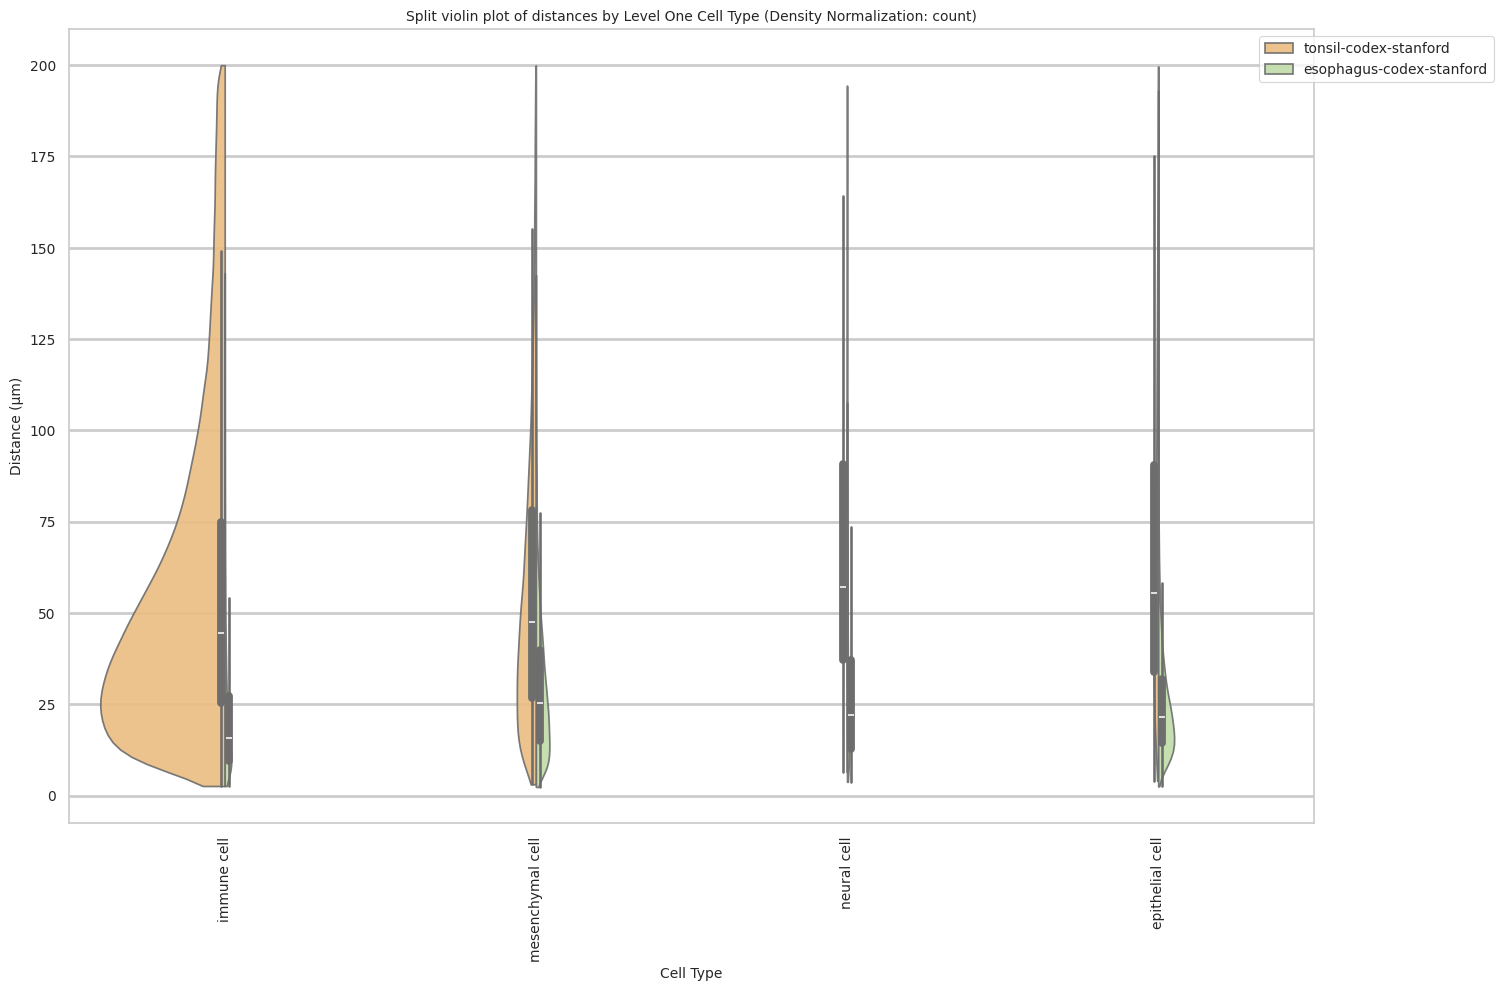

In [32]:
# Generate Split Violin Plot
def plot_violin_cells_per_celltype_split_by_condition(df_all_edges_with_cell_type_level, cell_type_level, output_dir, density_norm="area"):
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={"grid.linewidth": 2})
    plt.figure(figsize=(15, 10))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path

    sns.violinplot(data=df_all_edges_with_cell_type_level, x=cell_type_level, y="Distance", hue="Unique Region", density_norm=density_norm, common_norm=True, cut=0, inner="box", split=True, palette='Spectral', alpha=.9, hue_order=regions)

    sns.set_theme(style="whitegrid")
    sns.set_context("paper")


    font_size = 10
    plt.legend(fontsize=font_size, loc='upper right', bbox_to_anchor=(1.15, 1))

    plt.title(f'Split violin plot of distances by {cell_type_level} (Density Normalization: {density_norm})', fontsize=font_size)

    plt.xlabel('Cell Type', fontsize=font_size)
    plt.ylabel('Distance (\u03bcm)', fontsize=font_size)

    # Increase font size for all text in the figure
    plt.xticks(fontsize=font_size)
    plt.xticks(rotation=90)
    plt.yticks(fontsize=font_size)

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_plot_violin_cells_per_celltype_split_by_condition_{cell_type_level}.png'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_plot_violin_cells_per_celltype_split_by_condition_{cell_type_level}.svg'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.show()

plot_violin_cells_per_celltype_split_by_condition(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # density_norm="count" or "area" can be used based on preference.

### Level Two Cell Type Analysis

In [33]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level Two Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level Two Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,b cell,esophagus-codex-stanford,18.969648,16.016955,3.881453,126.909646
1,b cell,tonsil-codex-stanford,53.795103,45.373324,3.016000,199.787236
2,gland epithelium cell,esophagus-codex-stanford,24.161285,20.704132,2.528993,193.046457
3,lymphoid cell,esophagus-codex-stanford,22.645679,15.703303,2.639000,143.075846
4,lymphoid cell,tonsil-codex-stanford,71.002055,53.958434,3.016000,199.993437
5,muscle cell,esophagus-codex-stanford,29.075721,25.112275,3.371991,121.626183
6,muscle cell,tonsil-codex-stanford,14.724496,11.403859,4.214988,59.595818
7,neuron,esophagus-codex-stanford,26.639884,22.024674,3.788803,107.653801
8,neuron,tonsil-codex-stanford,66.127466,57.077850,6.409000,194.409948
9,paneth cell,esophagus-codex-stanford,40.358060,42.616011,4.586403,75.125232


In [34]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in tonsil-codex-stanford:
        Level Two Cell Type  mean_distance
1             lymphoid cell      71.002055
3                    neuron      66.127466
4  squamous epithelial cell      65.469626
5              stromal cell      57.484964
0                    b cell      53.795103

Bottom 5 cell types in tonsil-codex-stanford:
        Level Two Cell Type  mean_distance
4  squamous epithelial cell      65.469626
5              stromal cell      57.484964
0                    b cell      53.795103
6                    t cell      44.040178
2               muscle cell      14.724496

Top 5 cell types in esophagus-codex-stanford:
        Level Two Cell Type  mean_distance
5               paneth cell      40.358060
7  squamous epithelial cell      37.731198
8              stromal cell      30.144150
3               muscle cell      29.075721
4                    neuron      26.639884

Bottom 5 cell types in esophagus-codex-stanford:
           Level Two Cell Type  mean_d

In [35]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])



Top 5 cell types in tonsil-codex-stanford:
        Level Two Cell Type  median_distance
3                    neuron        57.077850
4  squamous epithelial cell        55.553479
1             lymphoid cell        53.958434
5              stromal cell        47.978342
0                    b cell        45.373324

Bottom 5 cell types in tonsil-codex-stanford:
  Level Two Cell Type  median_distance
1       lymphoid cell        53.958434
5        stromal cell        47.978342
0              b cell        45.373324
6              t cell        38.233451
2         muscle cell        11.403859

Top 5 cell types in esophagus-codex-stanford:
        Level Two Cell Type  median_distance
5               paneth cell        42.616011
7  squamous epithelial cell        35.148048
8              stromal cell        26.062121
3               muscle cell        25.112275
4                    neuron        22.024674

Bottom 5 cell types in esophagus-codex-stanford:
           Level Two Cell Type  median

In [36]:
calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                          mean    std  CV (%)
Unique Region                                
esophagus-codex-stanford  26.2  17.46    66.6
tonsil-codex-stanford     56.9  42.08    74.0

Cell Type Variability Analysis (sorted by CV):
                              mean    std  CV (%)
Level Two Cell Type                              
neuron                       31.35  24.62    78.5
lymphoid cell                67.06  52.45    78.2
stromal cell                 51.86  38.02    73.3
b cell                       52.62  36.47    69.3
squamous epithelial cell     60.43  39.56    65.5
t cell                       43.36  28.24    65.1
muscle cell                  28.84  18.34    63.6
gland epithelium cell        24.16  14.80    61.3
secretory cell of esophagus  24.73  14.31    57.9
paneth cell                  40.36  16.31    40.4


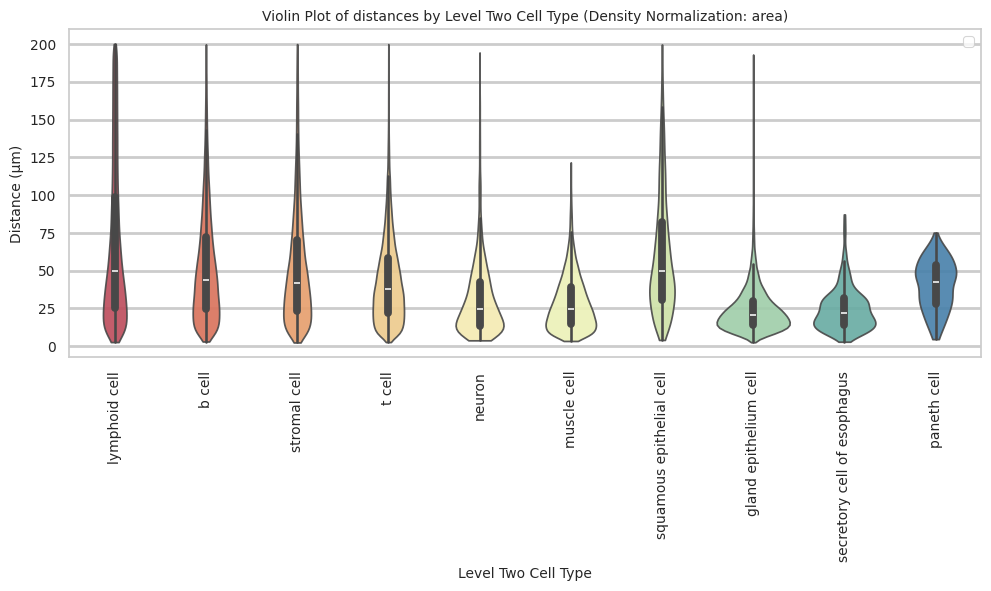

In [37]:
plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

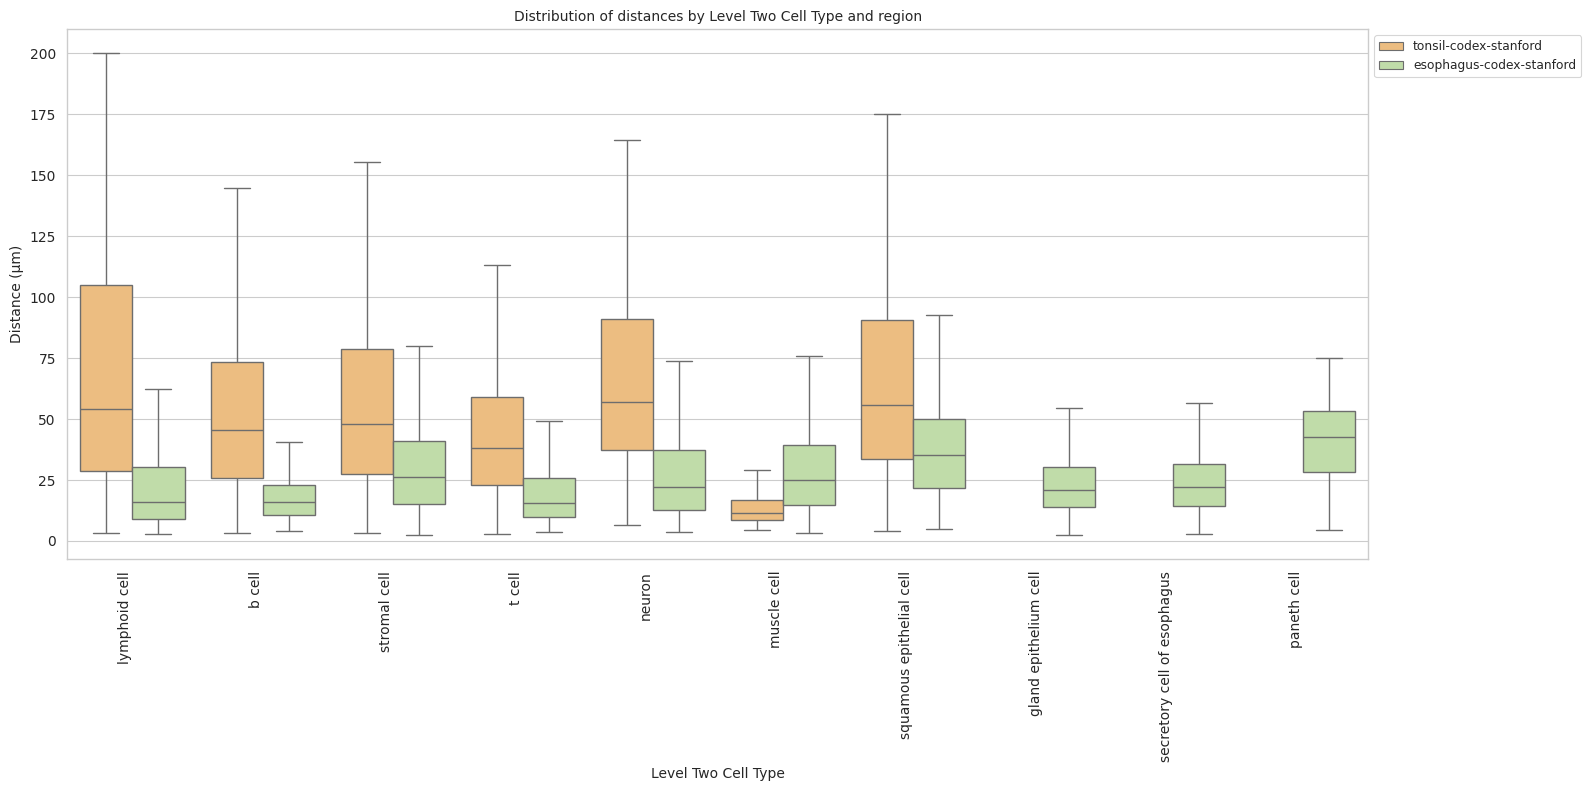

In [38]:
plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

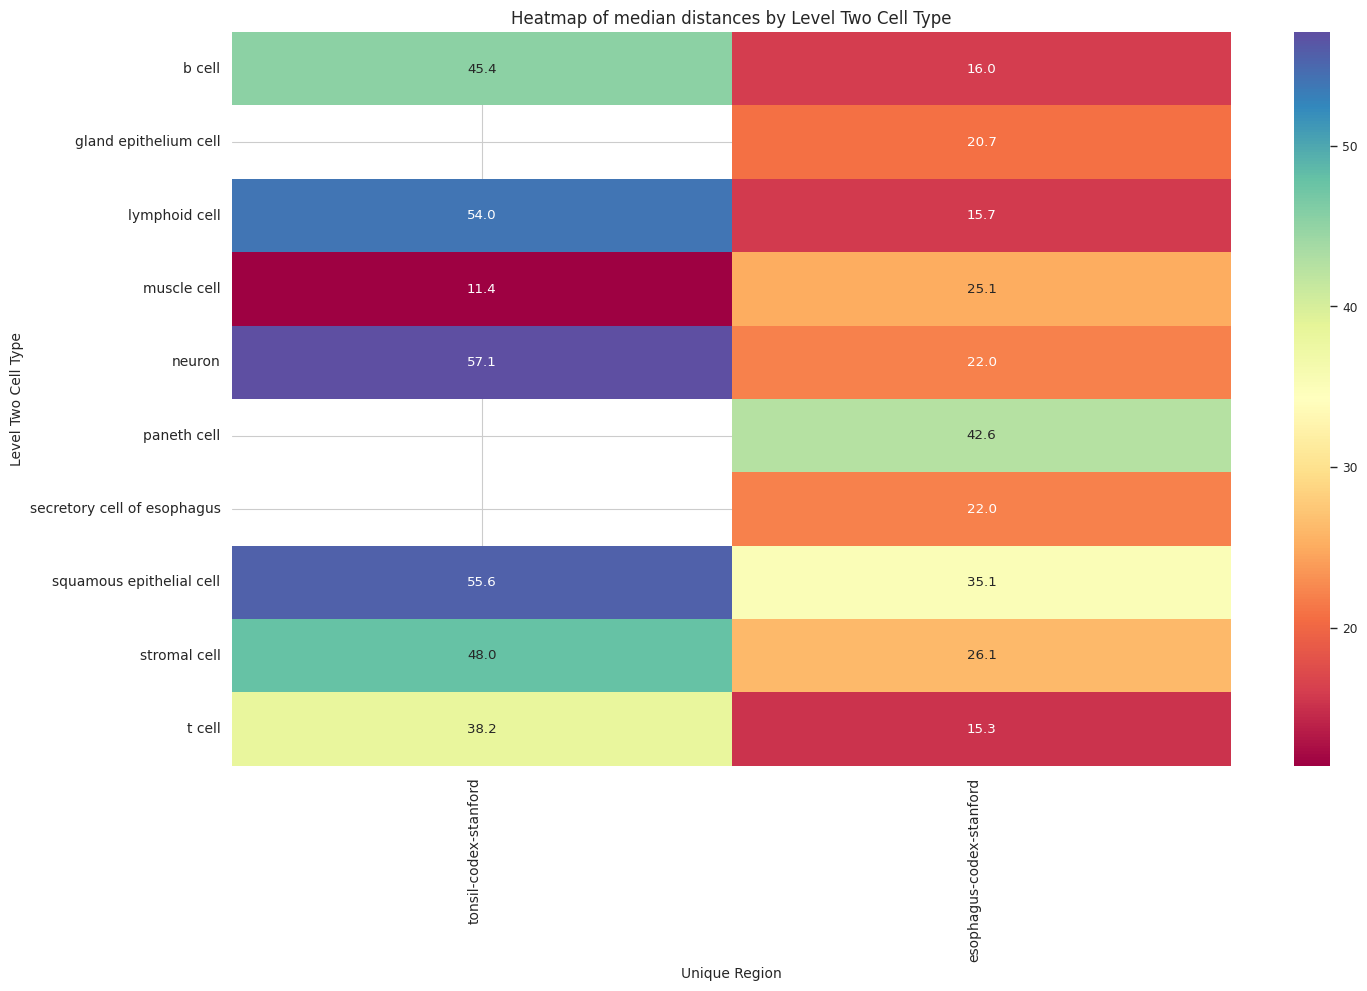

In [39]:
plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

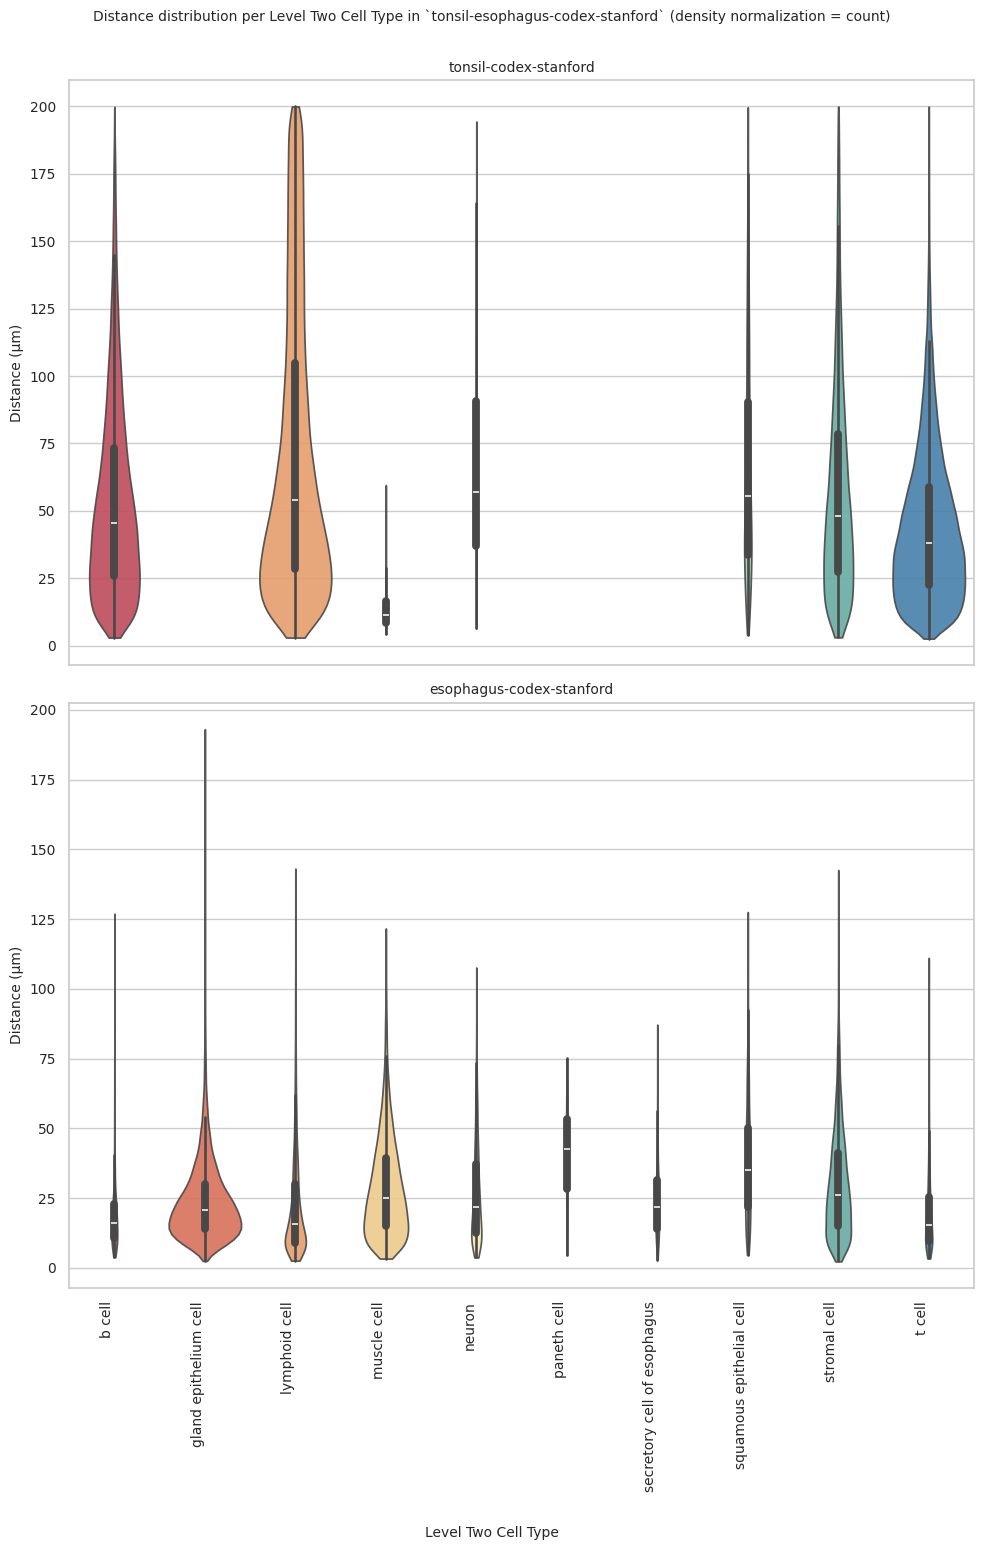

In [40]:
plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # Or, density_norm="count" or "area" based on preference.

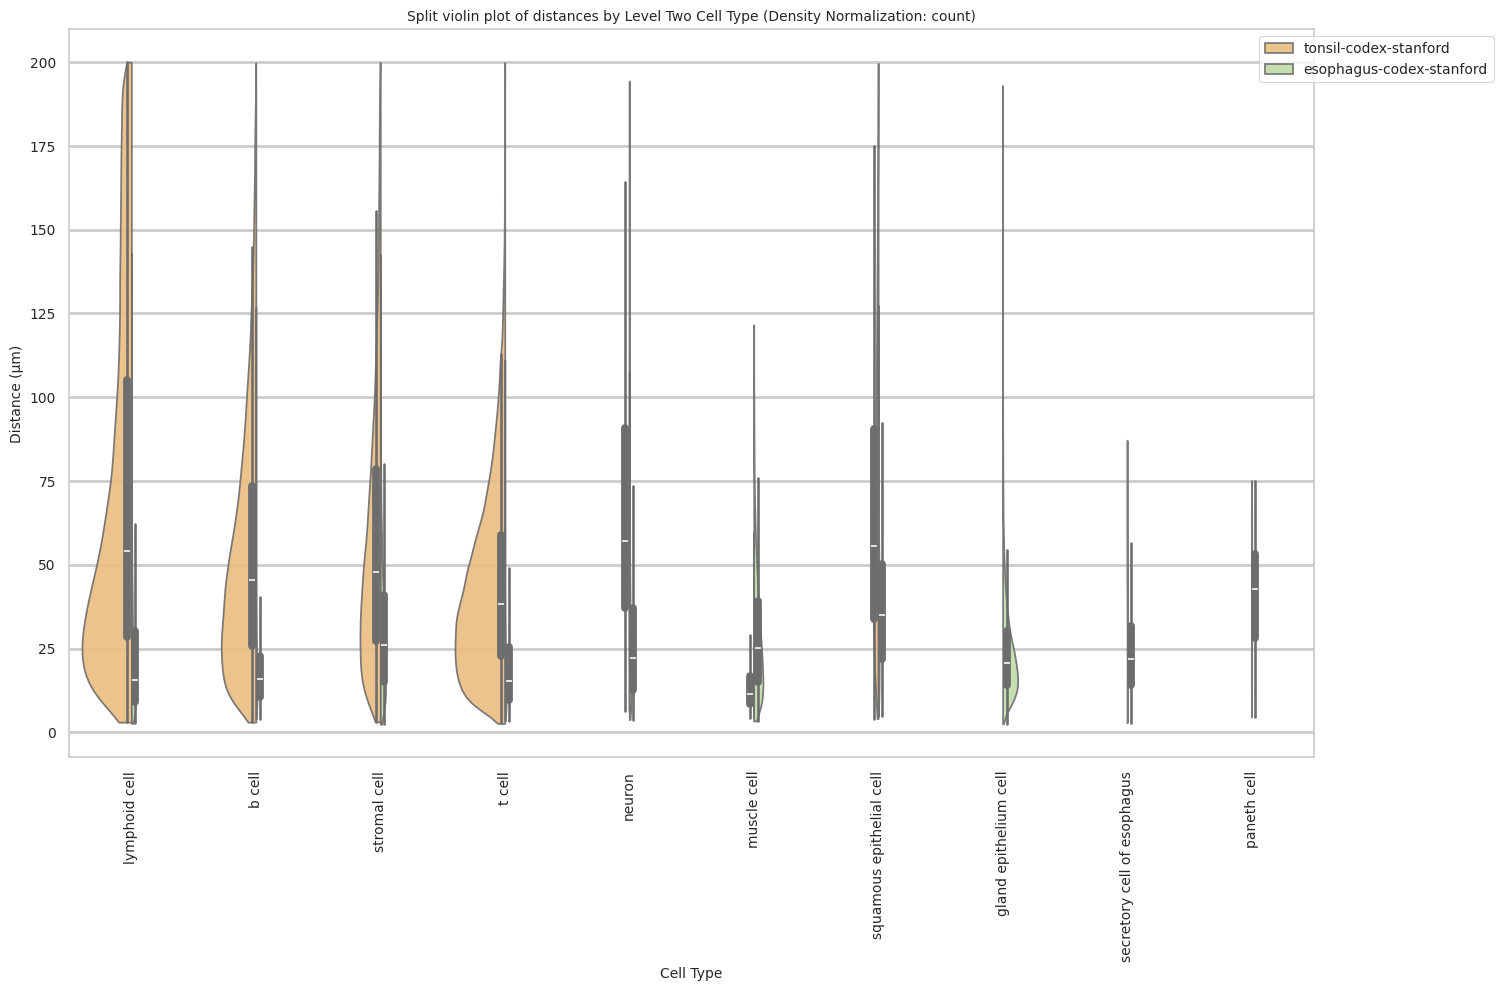

In [41]:
plot_violin_cells_per_celltype_split_by_condition(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # density_norm="count" or "area" can be used based on preference.

### Level Three Cell Type Analysis

In [42]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level Three Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level Three Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,b cell,tonsil-codex-stanford,55.759563,47.530416,3.016000,199.787236
1,epithelial cell:secretory,esophagus-codex-stanford,24.726692,22.005202,2.871146,87.171824
2,glandular cell of esophagus,esophagus-codex-stanford,24.161285,20.704132,2.528993,193.046457
3,lymphoid cell:innate,esophagus-codex-stanford,22.645679,15.703303,2.639000,143.075846
4,lymphoid cell:innate,tonsil-codex-stanford,71.002055,53.958434,3.016000,199.993437
5,muscle cell:smooth,esophagus-codex-stanford,29.075721,25.112275,3.371991,121.626183
6,muscle cell:smooth,tonsil-codex-stanford,14.724496,11.403859,4.214988,59.595818
7,neuron,esophagus-codex-stanford,26.639884,22.024674,3.788803,107.653801
8,neuron,tonsil-codex-stanford,66.127466,57.077850,6.409000,194.409948
9,paneth cell,esophagus-codex-stanford,40.358060,42.616011,4.586403,75.125232


In [43]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in tonsil-codex-stanford:
      Level Three Cell Type  mean_distance
1      lymphoid cell:innate      71.002055
3                    neuron      66.127466
5  squamous epithelial cell      65.469626
6              stromal cell      58.536073
7  stromal cell:podoplanin+      56.732338

Bottom 5 cell types in tonsil-codex-stanford:
      Level Three Cell Type  mean_distance
7  stromal cell:podoplanin+      56.732338
0                    b cell      55.759563
8                    t cell      44.040178
4               plasma cell      26.122452
2        muscle cell:smooth      14.724496

Top 5 cell types in esophagus-codex-stanford:
      Level Three Cell Type  mean_distance
5               paneth cell      40.358060
7  squamous epithelial cell      37.731198
9  stromal cell:podoplanin+      33.455139
8              stromal cell      29.426691
3        muscle cell:smooth      29.075721

Bottom 5 cell types in esophagus-codex-stanford:
          Level Three Cell Type  mean_

In [44]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in tonsil-codex-stanford:
      Level Three Cell Type  median_distance
3                    neuron        57.077850
5  squamous epithelial cell        55.553479
1      lymphoid cell:innate        53.958434
7  stromal cell:podoplanin+        48.751217
0                    b cell        47.530416

Bottom 5 cell types in tonsil-codex-stanford:
  Level Three Cell Type  median_distance
0                b cell        47.530416
6          stromal cell        46.646038
8                t cell        38.233451
4           plasma cell        18.626242
2    muscle cell:smooth        11.403859

Top 5 cell types in esophagus-codex-stanford:
      Level Three Cell Type  median_distance
5               paneth cell        42.616011
7  squamous epithelial cell        35.148048
9  stromal cell:podoplanin+        30.538157
3        muscle cell:smooth        25.112275
8              stromal cell        24.946174

Bottom 5 cell types in esophagus-codex-stanford:
          Level Three Cell

In [45]:
calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                          mean    std  CV (%)
Unique Region                                
esophagus-codex-stanford  26.2  17.46    66.6
tonsil-codex-stanford     56.9  42.08    74.0

Cell Type Variability Analysis (sorted by CV):
                              mean    std  CV (%)
Level Three Cell Type                            
plasma cell                  23.66  20.60    87.1
stromal cell                 48.70  39.75    81.6
neuron                       31.35  24.62    78.5
lymphoid cell:innate         67.06  52.45    78.2
squamous epithelial cell     60.43  39.56    65.5
b cell                       55.76  36.44    65.4
stromal cell:podoplanin+     55.02  35.92    65.3
t cell                       43.36  28.24    65.1
muscle cell:smooth           28.84  18.34    63.6
glandular cell of esophagus  24.16  14.80    61.3
epithelial cel

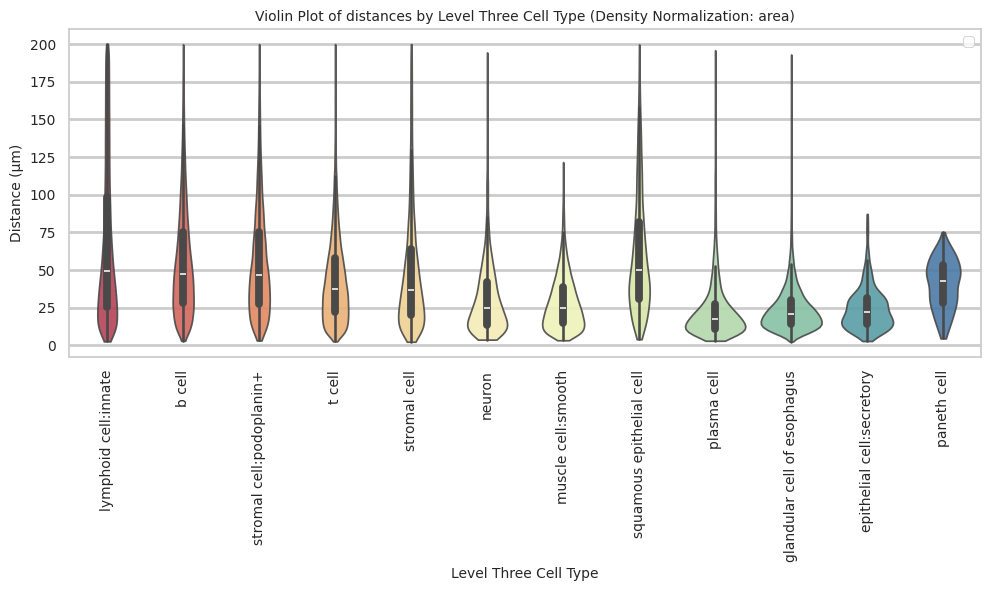

In [46]:
plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

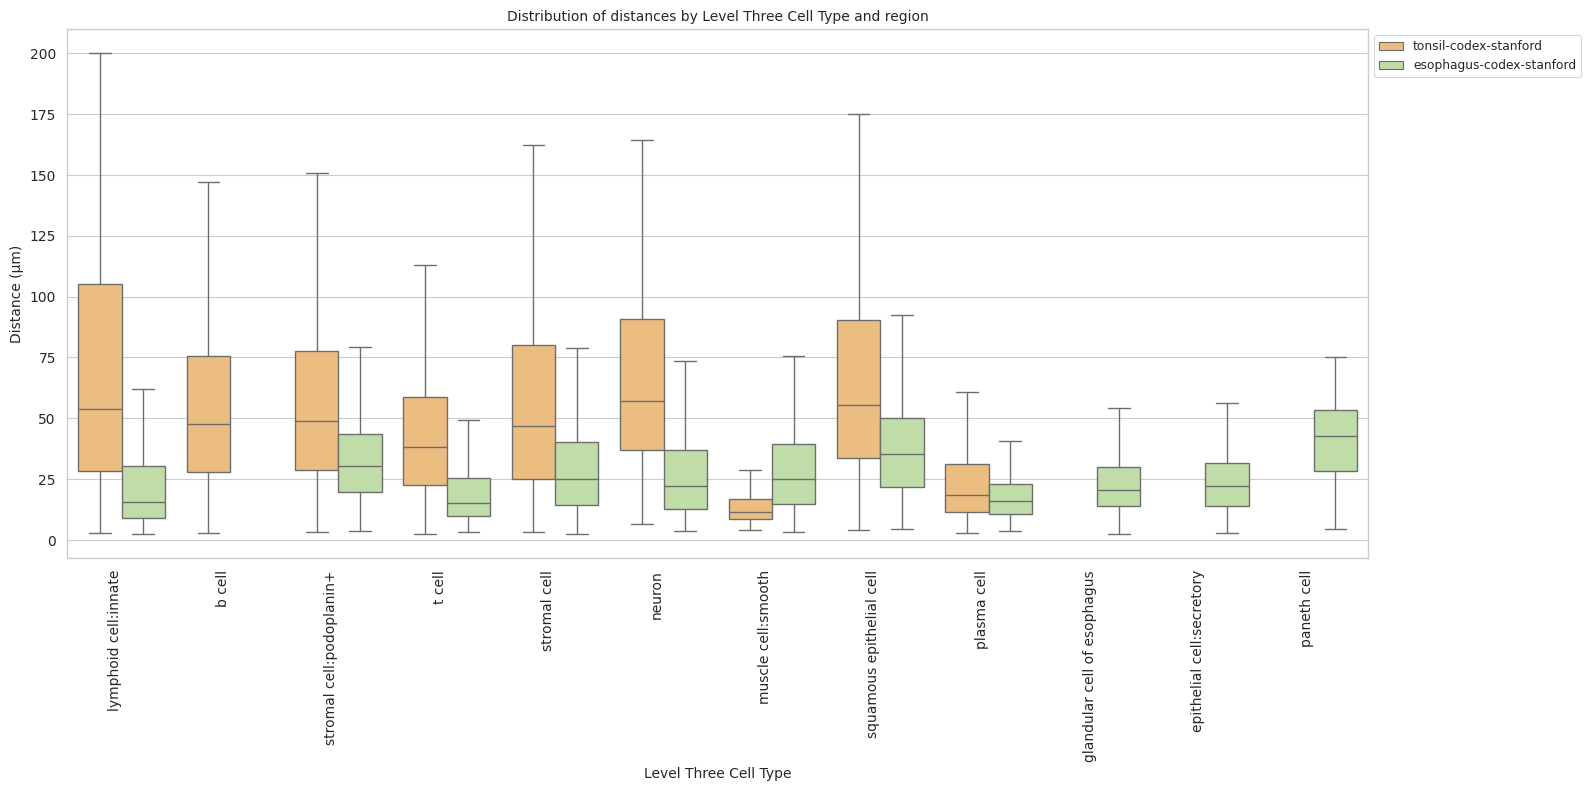

In [47]:
plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

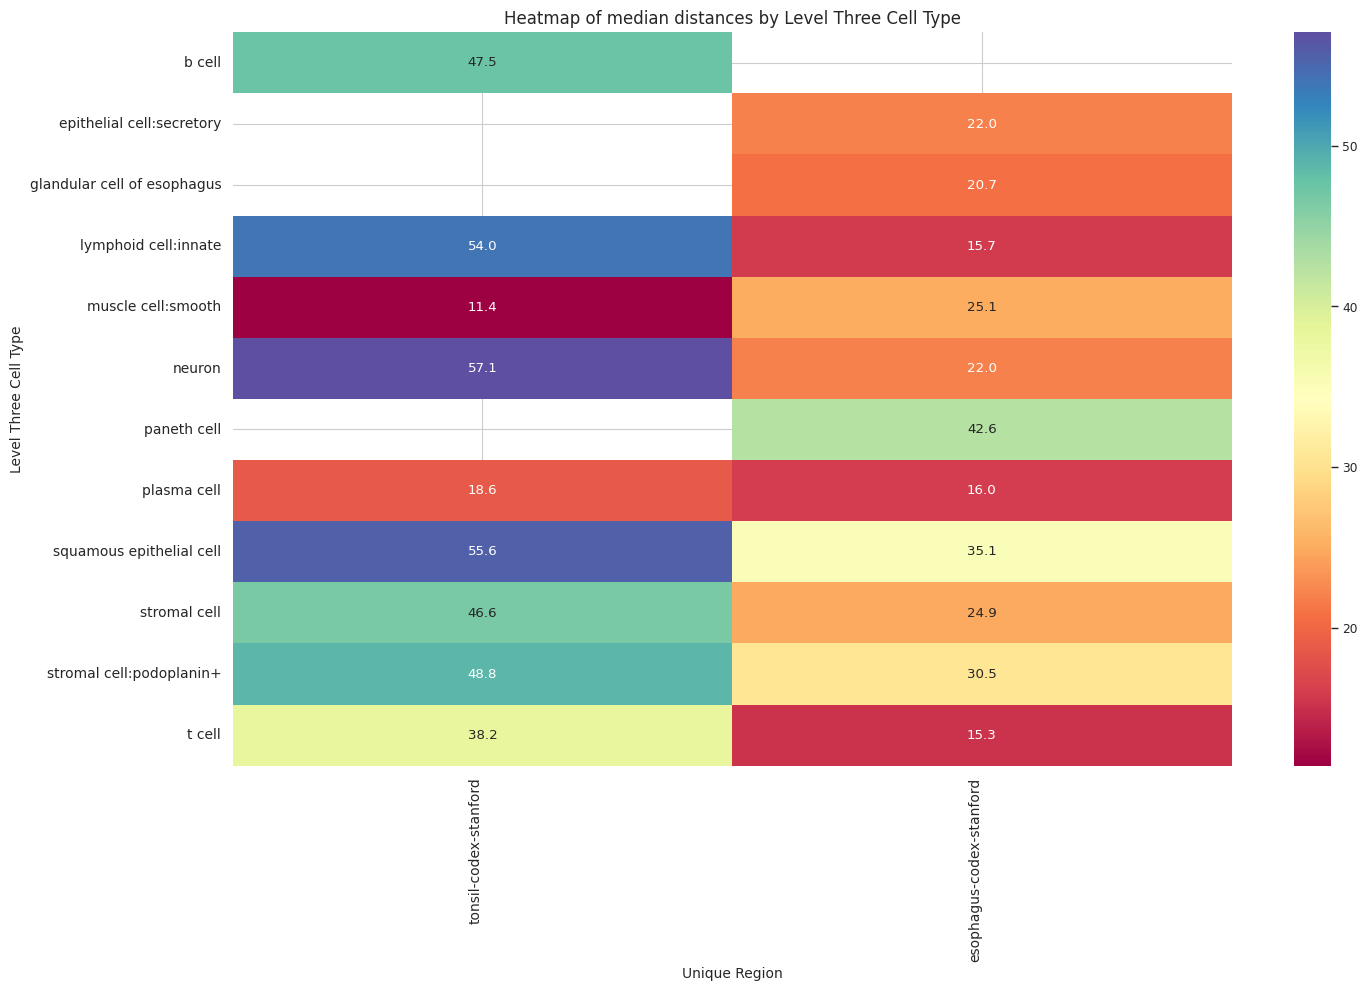

In [48]:
plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

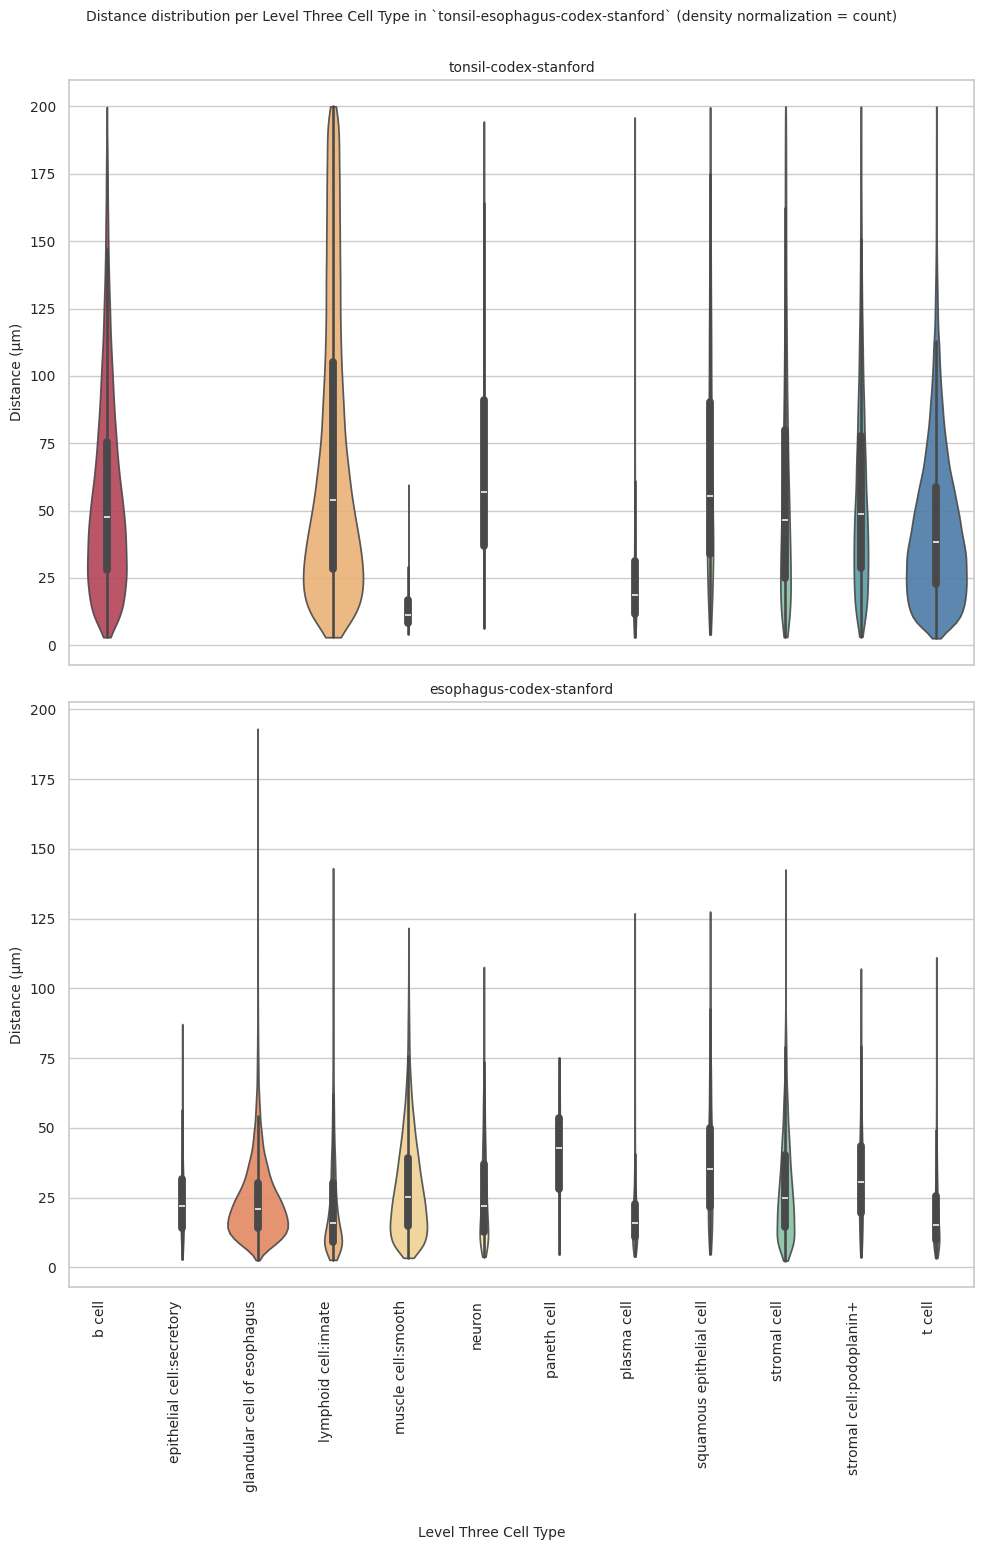

In [49]:
plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # Or, density_norm="count" or "area" based on preference.

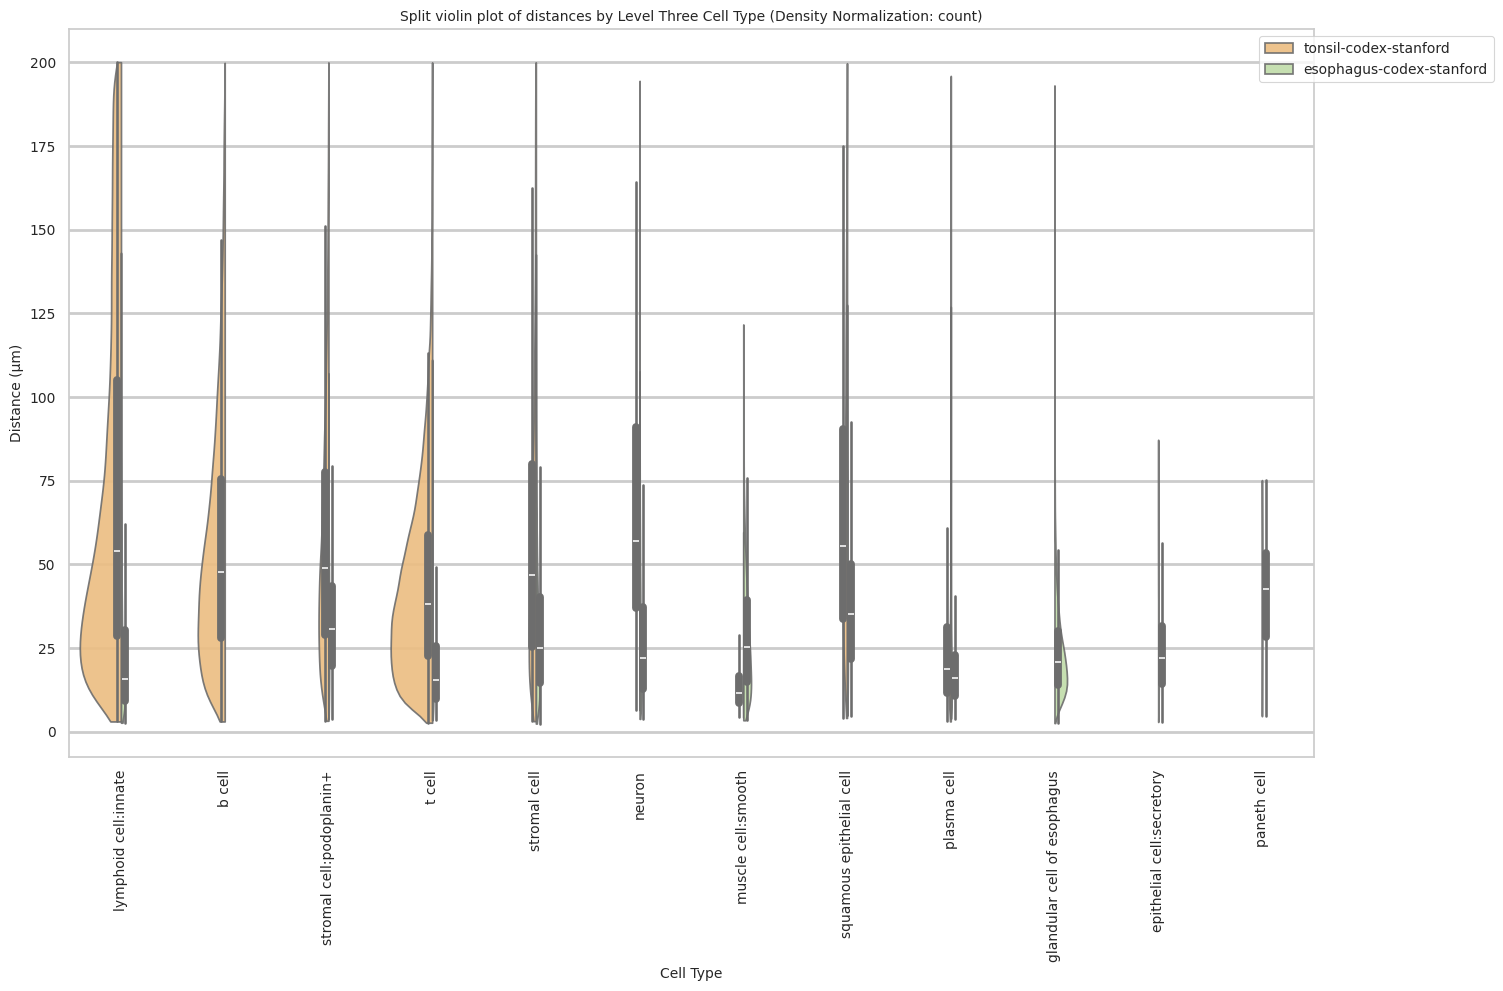

In [50]:
plot_violin_cells_per_celltype_split_by_condition(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # density_norm="count" or "area" can be used based on preference.